# FomulaBEAT

ポーランド記法から逆ポーランド記法へ変換するタスク

4-1-5からの変更点
- データを空白を削除したもの、さらに深さは0-2（03-6）で層ごとのサイズを同数に
- 次元を6次元にする



In [1]:
version = '04-2-2'
model_dir = './model/' + version
data_path = 'data/eq03-5.txt'
test_data_path = 'data/eq03-5-test.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['9', '++04+93', '++9+05+0+68'] ['9', '04+93++', '905++068+++']


辞書データの作成

In [7]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '<start>': 11, '<end>': 12, '<pad>': 13, '<unk>': 14}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[11, 10, 14, 10, 14, 1, 14, 5, 14, 10, 14, 8, 14, 5, 12]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([11, 10, 10, 10,  7,  4, 10,  4,  3,  7, 12])
Output: tensor([11,  7,  4, 10,  4,  3, 10, 10,  7, 10, 12])
元に戻した文章
Input: +++74+437
Output: 74+43++7+


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

800000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 4, padding_idx=13)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([15, 4])
値: Parameter containing:
tensor([[-0.3547,  0.4834,  0.4106,  0.5298],
        [ 0.0170, -0.5019,  0.4004,  0.1284],
        [-0.2205,  0.3060,  0.3274, -0.1949],
        [-0.1343,  0.4530,  0.5402,  0.0839],
        [-0.1522,  0.0621,  0.1177,  0.5369],
        [-0.1318,  0.5409,  0.1362,  0.4060],
        [-0.0562, -0.3907,  0.5014, -0.3882],
        [-0.0514,  0.4403, -0.2111, -0.1970],
        [ 0.1329, -0.1991, -0.3952,  0.3513],
        [-0.4574, -0.1256,  0.5025, -0.1864],
        [-0.0606, -0.5562,  0.4233,  0.3178],
        [ 0.3865,  0.3977, -0.4971, -0.5350],
        [-0.3311,  0.0008, -0.3810,  0.0996],
        [ 0.1857,  0.4597,  0.2067,  0.0784],
        [-0.2911, -0.0929, -0.3226, -0.2259]], device='cuda:0', requires_grad=True)

層名: decoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[ 0.5419,  0.3202, -0.2398,  0.5016],
        [ 0.1030, -0.0230,  0.4253,  0.52

## 学習実行

In [22]:
epoch = 20
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

  0%|          | 0/782 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 782/782 [00:11<00:00, 66.89it/s]


[1/20] train loss: 1.9798, valid loss: 1.5617  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.75it/s]


[2/20] train loss: 1.5102, valid loss: 1.4855  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.86it/s]


[3/20] train loss: 1.4745, valid loss: 1.4538  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.52it/s]


[4/20] train loss: 1.4342, valid loss: 1.4211  [12s] counter: 0 **


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


[5/20] train loss: 1.4152, valid loss: 1.4077  [9s] counter: 0 **


100%|██████████| 782/782 [00:08<00:00, 88.21it/s]


[6/20] train loss: 1.4027, valid loss: 1.3965  [9s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 70.92it/s]


[7/20] train loss: 1.3909, valid loss: 1.3846  [11s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 68.38it/s]


[8/20] train loss: 1.3854, valid loss: 1.3791  [11s] counter: 0 **


100%|██████████| 782/782 [00:10<00:00, 73.41it/s]


[9/20] train loss: 1.3818, valid loss: 1.3751  [11s] counter: 0 **


100%|██████████| 782/782 [00:08<00:00, 88.14it/s]


[10/20] train loss: 1.3883, valid loss: 1.3737  [9s] counter: 0 **


100%|██████████| 782/782 [00:08<00:00, 88.21it/s]


[11/20] train loss: 1.3812, valid loss: 1.3737  [9s] counter: 0 **


100%|██████████| 782/782 [00:08<00:00, 88.03it/s]


[12/20] train loss: 1.3918, valid loss: 1.3726  [9s] counter: 0 **


100%|██████████| 782/782 [00:10<00:00, 77.04it/s]


[13/20] train loss: 1.3753, valid loss: 1.3712  [10s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.84it/s]


[14/20] train loss: 1.3749, valid loss: 1.3708  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.89it/s]


[15/20] train loss: 1.3696, valid loss: 1.3688  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.86it/s]


[16/20] train loss: 1.3888, valid loss: 1.3687  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 68.10it/s]


[17/20] train loss: 1.3791, valid loss: 1.3681  [11s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.83it/s]


[18/20] train loss: 1.3677, valid loss: 1.3667  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 68.25it/s]


[19/20] train loss: 1.3844, valid loss: 1.3666  [11s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 67.85it/s]


[20/20] train loss: 1.3746, valid loss: 1.3663  [12s] counter: 0 **


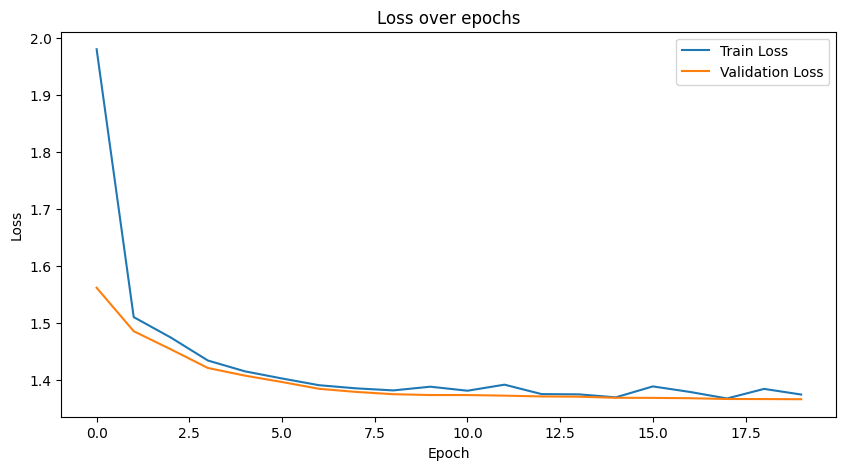

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

学習したモデルの保存

In [24]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [25]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.compute_output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [27]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

# 翻訳を実行
translation = translate(
    model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: ++15+85
Output: 00+0+++0+0+


In [28]:
# 様々な入力を試してみる

text_list = {
'5':'5',
'+62':'62+',
'+2+7+56':'2756+++',
'+++457+00':'45+7+00++',
# '+++91+96++820':'91+96++82+0++',
'+++43+52++99+12':'43+52++99+12+++',
'+1++48+17':'148+17+++',
'+0+82':'082++',
}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input  : {text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt}")
    print('---')


Input  : 5
Output : 0
Correct: 5
---
Input  : +62
Output : 00+
Correct: 62+
---
Input  : +2+7+56
Output : 00+0+++0+0+
Correct: 2756+++
---
Input  : +++457+00
Output : 00+0+++0+0+
Correct: 45+7+00++
---
Input  : +++43+52++99+12
Output : 00+0+0+0+++++
Correct: 43+52++99+12+++
---
Input  : +1++48+17
Output : 00+0+++0+0+
Correct: 148+17+++
---
Input  : +0+82
Output : 00+++
Correct: 082++
---


In [29]:
# テスト用ファイルの読み込み関数
def read_test_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    test_data = []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        test_data.append((src, tgt))
    return test_data

# 正答率を計算する関数
def calculate_accuracy(model, test_data, vocab_src, vocab_tgt, seq_len_tgt, START_IDX, END_IDX):
    correct = 0
    total = len(test_data)
    mistakes = []

    for src_text, tgt_text in test_data:
        # モデルを使って翻訳を実行
        translation = translate(
            model=model, text=src_text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
            seq_len_tgt=seq_len_tgt,
            START_IDX=START_IDX, END_IDX=END_IDX
        )

        # 正答のチェック
        if translation == tgt_text:
            correct += 1
        else:
            # 間違えたものを保存
            mistakes.append((src_text, translation, tgt_text))

    accuracy = correct / total * 100
    return accuracy, mistakes


# テストデータの読み込み
test_data = read_test_file(test_data_path)

# 正答率の計算（間違いの詳細も取得）
accuracy, mistakes = calculate_accuracy(
    model=loaded_model, test_data=test_data,
    vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 2.85%
Mistakes: 1943 out of 2000

Examples of mistakes:
Input  : +97
Output : 00+
Correct: 97+
---
Input  : ++87+81
Output : 00+0+++0+0+
Correct: 87+81++
---
Input  : +++19+61++71+46
Output : 00+0+0+0+++++
Correct: 19+61++71+46+++
---
Input  : +58
Output : 00+
Correct: 58+
---
Input  : ++62+29
Output : 00+0+++0+0+
Correct: 62+29++
---
Input  : +++59+276
Output : 00+0+++0+0+
Correct: 59+27++6+
---
Input  : +46
Output : 00+
Correct: 46+
---
Input  : +9+52
Output : 00+++
Correct: 952++
---
Input  : +0++750
Output : 00+0+++0+0+
Correct: 075+0++
---
Input  : +44
Output : 00+
Correct: 44+
---


In [30]:
# +の位置が正しいかをチェックする関数
def check_plus_positions(src_text, tgt_text, translation):
    # +の位置だけに注目して比較
    src_plus_positions = [i for i, char in enumerate(src_text) if char == '+']
    tgt_plus_positions = [i for i, char in enumerate(tgt_text) if char == '+']
    translation_plus_positions = [i for i, char in enumerate(translation) if char == '+']
    
    # 正解ターゲットと翻訳結果の+の位置を比較
    return tgt_plus_positions == translation_plus_positions

# 正答率を計算する関数（+の位置にフォーカス）
def calculate_plus_position_accuracy(model, test_data, vocab_src, vocab_tgt, seq_len_tgt, START_IDX, END_IDX):
    correct = 0
    total = len(test_data)
    mistakes = []

    for src_text, tgt_text in test_data:
        # モデルを使って翻訳を実行
        translation = translate(
            model=model, text=src_text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
            seq_len_tgt=seq_len_tgt,
            START_IDX=START_IDX, END_IDX=END_IDX
        )

        # +の位置が正しいかを確認
        if check_plus_positions(src_text, tgt_text, translation):
            correct += 1
        else:
            # 間違えたものを保存
            mistakes.append((src_text, translation, tgt_text))

    accuracy = correct / total * 100
    return accuracy, mistakes


# テストデータの読み込み
test_data = read_test_file(test_data_path)

# 正答率の計算（間違いの詳細も取得）
accuracy, mistakes = calculate_plus_position_accuracy(
    model=loaded_model, test_data=test_data,
    vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

# 正答率の表示
print(f"Test Accuracy (based on + positions): {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy (based on + positions): 59.75%
Mistakes: 805 out of 2000

Examples of mistakes:
Input  : ++87+81
Output : 00+0+++0+0+
Correct: 87+81++
---
Input  : +++19+61++71+46
Output : 00+0+0+0+++++
Correct: 19+61++71+46+++
---
Input  : ++62+29
Output : 00+0+++0+0+
Correct: 62+29++
---
Input  : +++59+276
Output : 00+0+++0+0+
Correct: 59+27++6+
---
Input  : +9+52
Output : 00+++
Correct: 952++
---
Input  : +0++750
Output : 00+0+++0+0+
Correct: 075+0++
---
Input  : ++08+41
Output : 00+0+++0+0+
Correct: 08+41++
---
Input  : +++496++67+12
Output : 00+0+0+0+0+++
Correct: 49+6+67+12+++
---
Input  : ++4+43+5+24
Output : 00+0+++0+0+++
Correct: 443++524+++
---
Input  : ++65+89
Output : 00+0+++0+0+
Correct: 65+89++
---


# モデルの動作を分析

In [42]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 4, padding_idx=13)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [43]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([15, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])


In [44]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [45]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Attentionを確認

In [47]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: ++15+85
memory: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.1814, -1.8499,  1.3101,  2.5170]],

        [[ 0.2492, -2.8064,  1.3201,  2.5169]],

        [[-0.4127, -0.4247,  0.6257,  0.2290]],

        [[-1.3087, -0.0897,  0.6242,  0.2275]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.8327,  1.5232,  0.6538,  0.2272]],

        [[ 0.1051,  1.3178,  0.6542,  0.2259]],

        [[ 0.3699, -0.1823, -3.7036,  5.0313]]], device='cuda:0')
memory_size: torch.Size([9, 1, 4])

------------------

iter: 0
ys: tensor([[11]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
self_attention: 
[[1.]]
tgt_tokens: ['<start>']
QV.shape: torch.Siz

text: ++15+85
memory: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.1814, -1.8499,  1.3101,  2.5170]],

        [[ 0.2492, -2.8064,  1.3201,  2.5169]],

        [[-0.4127, -0.4247,  0.6257,  0.2290]],

        [[-1.3087, -0.0897,  0.6242,  0.2275]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.8327,  1.5232,  0.6538,  0.2272]],

        [[ 0.1051,  1.3178,  0.6542,  0.2259]],

        [[ 0.3699, -0.1823, -3.7036,  5.0313]]], device='cuda:0')
memory_size: torch.Size([9, 1, 4])

------------------

iter: 0
ys: tensor([[11]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
self_attention: 
[[1.]]
tgt_tokens: ['<start>']


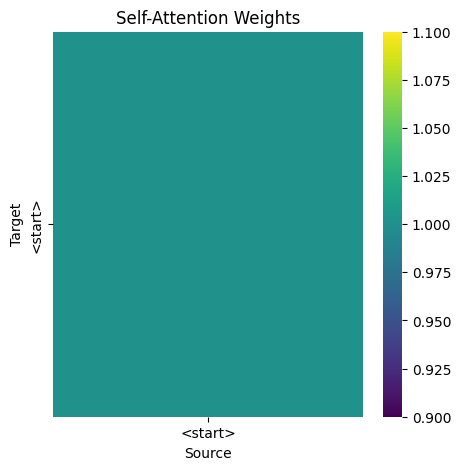

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[0.01125909 0.1170143  0.12595937 0.09349308 0.1417981  0.30170977
  0.09347926 0.05944853 0.05583853]]
After Attention: tensor([[[-4.7499,  0.8408,  6.2076, -3.3825]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


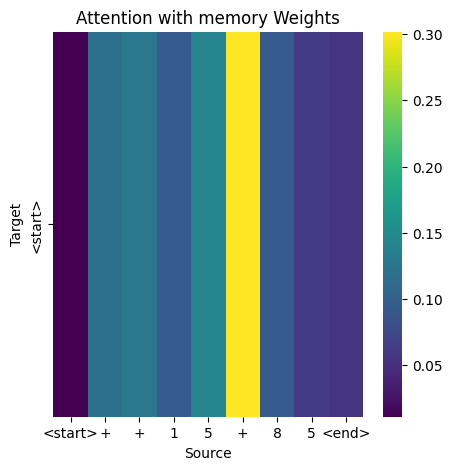

output.shape: torch.Size([1, 15])
output: tensor([[  4.7120,   4.7053,   4.6752,   4.6931,   4.6941,   4.6664,   4.6655,   4.7001,   4.6976,
           4.6887,   2.0324,  -7.4129, -17.1109,  -8.2308,  -7.7813]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[11],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
self_attention: 
[[0.00155117 0.99844885]
 [0.07314991 0.92685014]]
tgt_tokens: ['<start>', '0']


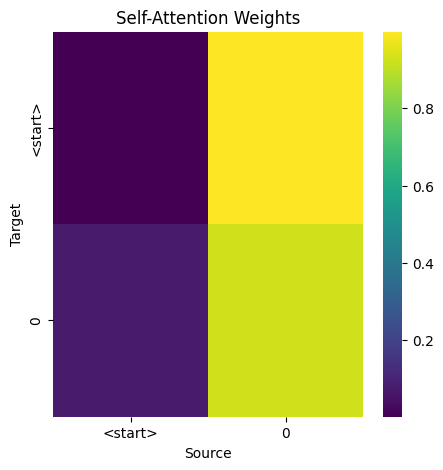

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 4])
multi_attention: 
[[2.7732824e-07 1.4902471e-02 1.7409816e-02 4.6687261e-03 3.0908324e-02
  9.2429018e-01 6.6521191e-03 8.7691104e-04 2.9112175e-04]
 [1.5183511e-01 4.6613406e-02 3.2711770e-02 8.4895357e-02 1.2212851e-01
  6.9586322e-02 1.8759105e-01 1.3488205e-01 1.6975647e-01]]
After Attention: tensor([[[-4.4900,  0.3135,  6.5280, -3.4270]],

        [[-4.2056,  0.5924,  6.3720, -4.1245]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


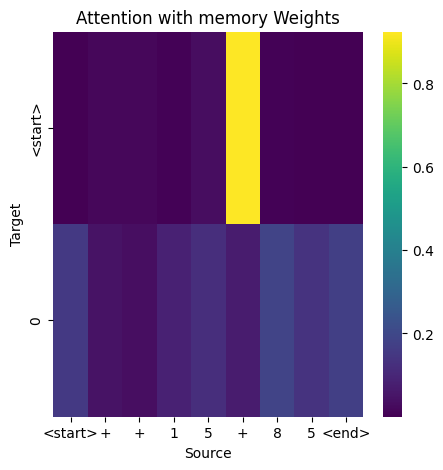

output.shape: torch.Size([1, 15])
output: tensor([[  4.8251,   4.8192,   4.7893,   4.8080,   4.8084,   4.7804,   4.7805,   4.8138,   4.8120,
           4.8027,   1.6938,  -6.3925, -19.0827,  -7.2118,  -6.7430]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 2
ys: tensor([[11],
        [ 0],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]]], device='cuda:0')
now tgt: 00
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
self_attention: 
[[3.1049777e-04 1.9986001e-01 7.9982954e-01]
 [2.2361279e-02 2.8332

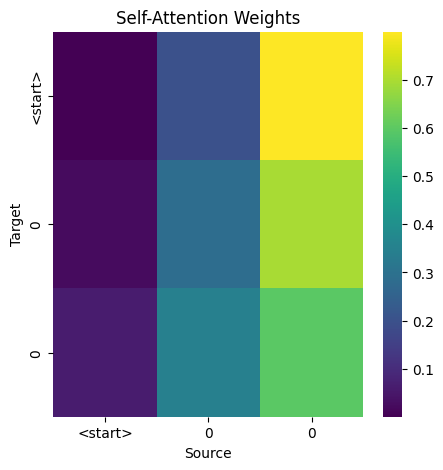

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 4])
multi_attention: 
[[1.80155482e-07 1.48381861e-02 1.84232891e-02 4.11528628e-03
  2.65736133e-02 9.29964364e-01 5.18552214e-03 6.95231953e-04
  2.04202574e-04]
 [4.22937264e-05 2.71170437e-02 1.92635972e-02 2.22263392e-02
  1.24245025e-01 7.11927414e-01 7.69513175e-02 1.31145343e-02
  5.11240028e-03]
 [1.13694482e-01 6.20657811e-03 1.92746939e-03 3.19138207e-02
  9.85179991e-02 2.01688521e-02 4.32608753e-01 1.57349780e-01
  1.37612268e-01]]
After Attention: tensor([[[-4.4801,  0.0776,  6.6391, -3.2273]],

        [[-3.9036, -0.9363,  6.9942, -3.0996]],

        [[-1.8750, -3.1469,  6.5774, -2.5498]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


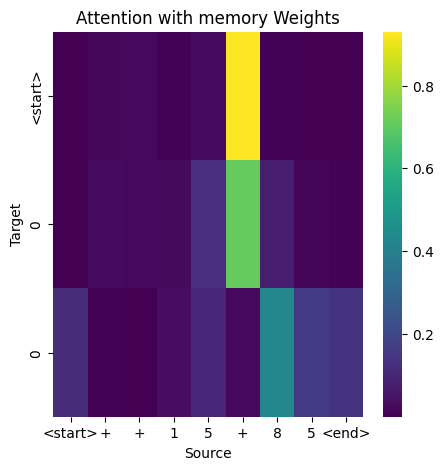

output.shape: torch.Size([1, 15])
output: tensor([[  2.5775,   2.5714,   2.5471,   2.5637,   2.5647,   2.5353,   2.5378,   2.5651,   2.5686,
           2.5531,   6.7215,  -8.6952, -16.9477,  -7.9931,  -7.5560]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 0],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]]], device='cuda:0')
now tgt: 00+
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV

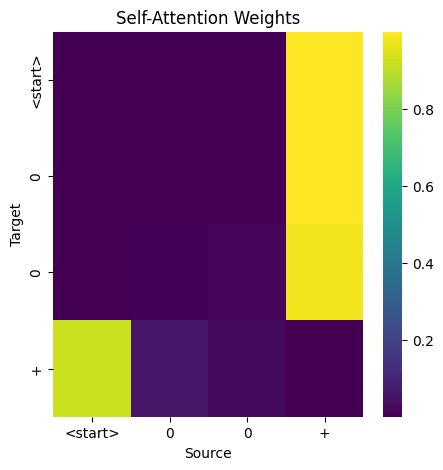

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 4])
multi_attention: 
[[4.2867291e-06 4.4395082e-02 6.3027799e-02 1.2441543e-02 4.2153519e-02
  8.2494438e-01 9.7744009e-03 2.5411323e-03 7.1783119e-04]
 [1.8908189e-05 6.4138867e-02 9.0940334e-02 1.9915286e-02 5.4148849e-02
  7.5006622e-01 1.4549512e-02 4.7762892e-03 1.4456917e-03]
 [2.8864612e-05 6.8338536e-02 9.4269790e-02 2.2645678e-02 5.9764098e-02
  7.3000425e-01 1.7251922e-02 5.8702421e-03 1.8266003e-03]
 [2.9116064e-01 9.4613306e-02 1.0667324e-01 9.8546147e-02 7.0638649e-02
  5.3029131e-02 6.9835894e-02 9.7528696e-02 1.1797430e-01]]
After Attention: tensor([[[-4.4813, -0.8207,  6.9101, -2.2034]],

        [[-4.4879, -1.0131,  6.9322, -1.9266]],

        [[-4.4657, -1.0649,  6.9428, -1.8981]],

        [[-5.7880,  1.8934,  4.9499, -1.6190]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


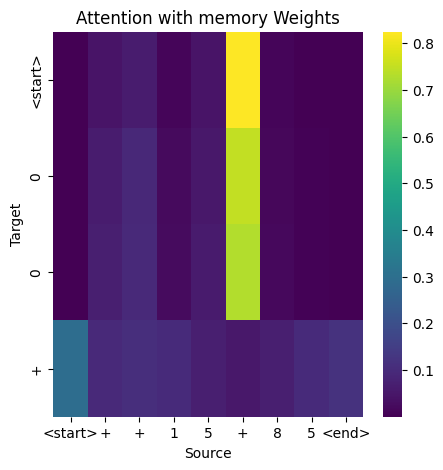

output.shape: torch.Size([1, 15])
output: tensor([[  4.2437,   4.2362,   4.2091,   4.2231,   4.2249,   4.2018,   4.1985,   4.2327,   4.2279,
           4.2221,   1.6372,  -8.2654, -10.8721,  -9.3273,  -8.9041]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 4
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]]], device='cuda:0')
now tgt: 00+0
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 5,

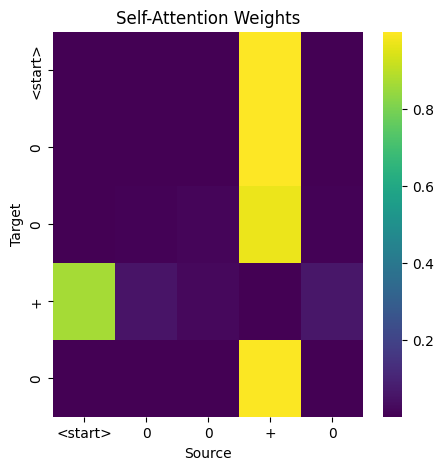

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 4])
multi_attention: 
[[4.28613066e-06 4.43942361e-02 6.30273744e-02 1.24409925e-02
  4.21518721e-02 8.24948788e-01 9.77375824e-03 2.54094601e-03
  7.17772054e-04]
 [1.89070906e-05 6.41397908e-02 9.09435451e-02 1.99149530e-02
  5.41469790e-02 7.50065565e-01 1.45486007e-02 4.77606151e-03
  1.44561252e-03]
 [2.88601605e-05 6.83880597e-02 9.43922549e-02 2.26450190e-02
  5.97212575e-02 7.29904890e-01 1.72286145e-02 5.86605817e-03
  1.82506756e-03]
 [3.19126844e-01 9.18384865e-02 1.04763269e-01 9.53823775e-02
  6.55630827e-02 4.77025732e-02 6.51717633e-02 9.49752554e-02
  1.15476355e-01]
 [2.81285993e-05 7.43335411e-02 1.09898478e-01 2.24834681e-02
  5.46513833e-02 7.16995537e-01 1.46028874e-02 5.36280125e-03
  1.64376502e-03]]
After Attention: tensor([[[-4.4813e+00, -8.2069e-01,  6.9100e+00, -2.2034e+00]],

        [[-4.4879e+0

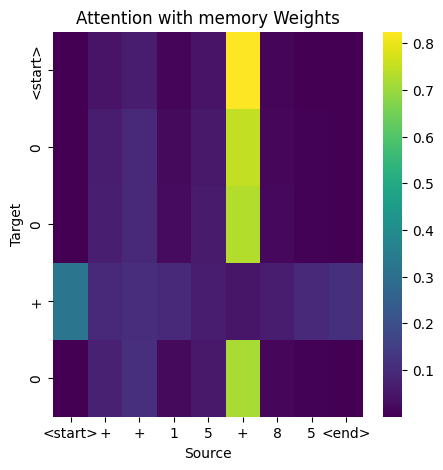

output.shape: torch.Size([1, 15])
output: tensor([[  3.7068,   3.6981,   3.6675,   3.6851,   3.6877,   3.6557,   3.6552,   3.6918,   3.6917,
           3.6782,   5.9220, -11.1719, -15.2315, -11.0406, -10.6467]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 5
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]]], device='cuda:0')
now tgt: 00+0+
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],


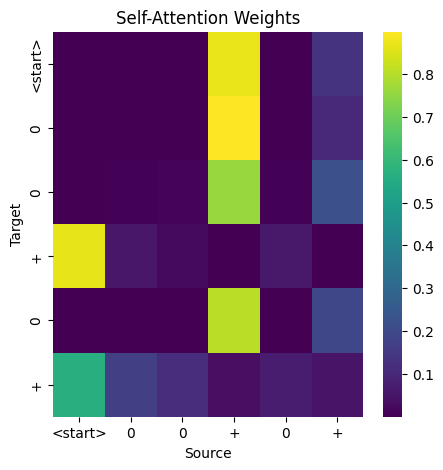

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 4])
multi_attention: 
[[4.32565093e-06 4.50684689e-02 6.45680204e-02 1.24885850e-02
  4.17845435e-02 8.23244989e-01 9.60247591e-03 2.52629886e-03
  7.12223060e-04]
 [1.90931805e-05 6.49237484e-02 9.27390307e-02 1.99796930e-02
  5.37472516e-02 7.48057485e-01 1.43401874e-02 4.75557894e-03
  1.43789151e-03]
 [2.93859430e-05 7.01558590e-02 9.84115899e-02 2.27782670e-02
  5.87181561e-02 7.25627780e-01 1.66760013e-02 5.80206048e-03
  1.80092733e-03]
 [3.19400042e-01 9.17968079e-02 1.04717255e-01 9.53486487e-02
  6.55212924e-02 4.76532280e-02 6.51405975e-02 9.49581787e-02
  1.15463905e-01]
 [2.86919803e-05 7.60138109e-02 1.13972880e-01 2.26114877e-02
  5.38452640e-02 7.12382674e-01 1.41999107e-02 5.31782582e-03
  1.62749912e-03]
 [3.02191198e-01 1.30099922e-01 1.92149237e-01 9.59465653e-02
  4.82615754e-02 4.56467345e-02 3.6116134

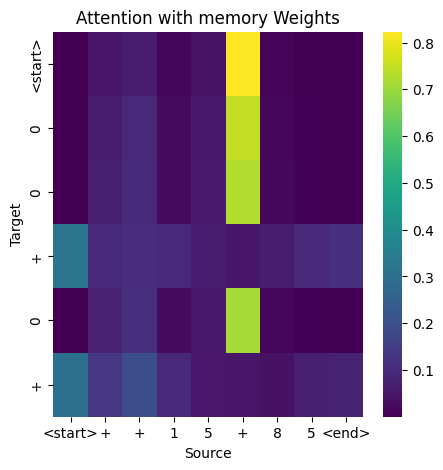

output.shape: torch.Size([1, 15])
output: tensor([[  1.7355,   1.7263,   1.7092,   1.7137,   1.7176,   1.7032,   1.6964,   1.7254,   1.7197,
           1.7161,   4.2436, -11.6569,   3.6829, -12.1947, -11.8487]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.9395, -1.4301,  1.3601,  2.5153]]], device='cuda:0')
now tgt: 00+0++
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.33

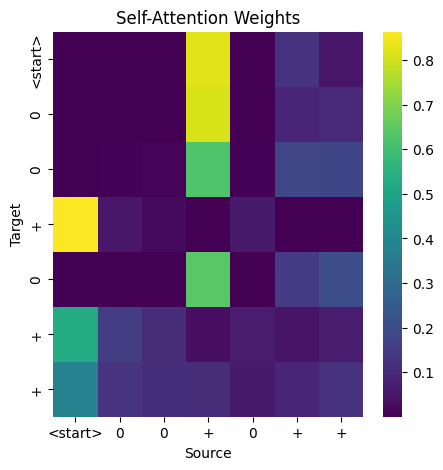

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 4])
multi_attention: 
[[4.34248614e-06 4.51208800e-02 6.46504834e-02 1.25044761e-02
  4.18077298e-02 8.23058188e-01 9.61026270e-03 2.53022416e-03
  7.13424932e-04]
 [1.97024638e-05 6.54461235e-02 9.35236961e-02 2.01737601e-02
  5.39854653e-02 7.46134758e-01 1.44422911e-02 4.81580896e-03
  1.45832531e-03]
 [3.13574201e-05 7.11044222e-02 9.96196419e-02 2.32287832e-02
  5.93836084e-02 7.21808672e-01 1.69971306e-02 5.96725801e-03
  1.85909029e-03]
 [3.19695979e-01 9.17480588e-02 1.04660653e-01 9.53115672e-02
  6.54776841e-02 4.75997999e-02 6.51103109e-02 9.49419886e-02
  1.15453966e-01]
 [3.10770665e-05 7.74862841e-02 1.16274029e-01 2.31564455e-02
  5.44229411e-02 7.06998944e-01 1.44548947e-02 5.48852095e-03
  1.68691971e-03]
 [3.60684574e-01 1.24569818e-01 1.95547730e-01 8.70359018e-02
  3.80899981e-02 3.47277969e-02 2.7836665

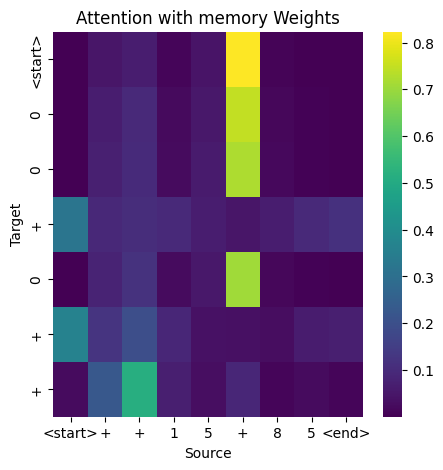

output.shape: torch.Size([1, 15])
output: tensor([[  2.3711,   2.3601,   2.3339,   2.3453,   2.3502,   2.3229,   2.3189,   2.3556,   2.3535,
           2.3421,   7.5851, -14.6313,  -4.4756, -14.3158, -13.9943]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]]], device='cuda:0')
now tgt: 00+0+++

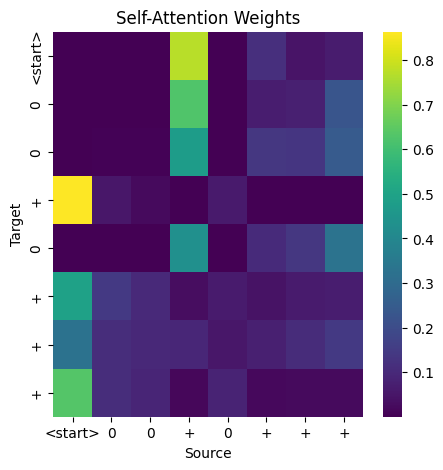

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 4])
multi_attention: 
[[4.3586110e-06 4.4886902e-02 6.4032570e-02 1.2514534e-02 4.2046458e-02
  8.2353520e-01 9.7148428e-03 2.5462939e-03 7.1888644e-04]
 [2.1639549e-05 6.5451451e-02 9.1978177e-02 2.0752445e-02 5.5903386e-02
  7.4386144e-01 1.5370558e-02 5.1027983e-03 1.5581488e-03]
 [3.5198675e-05 7.1052931e-02 9.7492285e-02 2.4041098e-02 6.1976027e-02
  7.1862429e-01 1.8353567e-02 6.4075147e-03 2.0170882e-03]
 [3.1982368e-01 9.1724843e-02 1.0463215e-01 9.5295243e-02 6.5459862e-02
  4.7576744e-02 6.5099321e-02 9.4936408e-02 1.1545181e-01]
 [3.6591013e-05 7.8030765e-02 1.1433914e-01 2.4323715e-02 5.7442605e-02
  7.0200533e-01 1.5910033e-02 6.0326140e-03 1.8791707e-03]
 [4.2834836e-01 1.1545516e-01 1.9246168e-01 7.6563053e-02 2.8953552e-02
  2.5190210e-02 2.0795913e-02 5.3789515e-02 5.8442596e-02]
 [2.0533577e-03 1.9687863e-

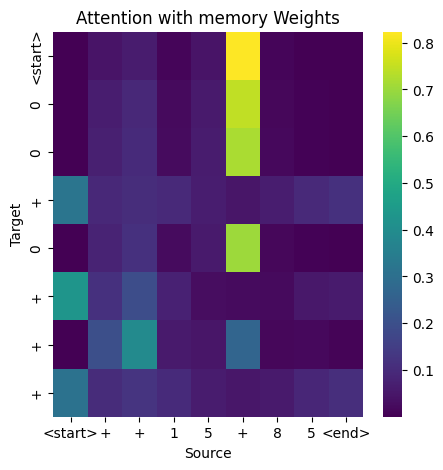

output.shape: torch.Size([1, 15])
output: tensor([[  3.2530,   3.2447,   3.2221,   3.2316,   3.2344,   3.2160,   3.2106,   3.2427,   3.2369,
           3.2329,   2.2744,  -9.5437,  -3.9353, -10.5321, -10.1415]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 8
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

        [[ 4.3396e-0

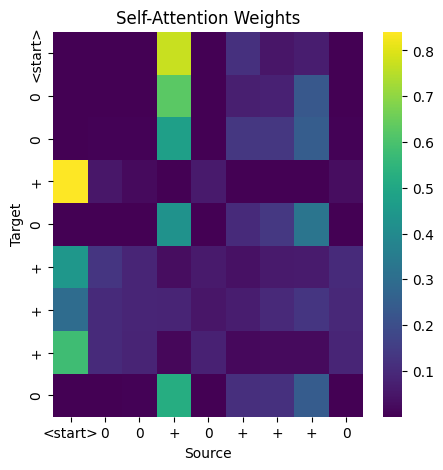

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 9, 9])
AV.shape: torch.Size([1, 9, 4])
multi_attention: 
[[4.35834409e-06 4.48860861e-02 6.40312806e-02 1.25142857e-02
  4.20460962e-02 8.23538125e-01 9.71472450e-03 2.54623266e-03
  7.18867755e-04]
 [2.16399367e-05 6.54503182e-02 9.19750631e-02 2.07525492e-02
  5.59046529e-02 7.43863404e-01 1.53712025e-02 5.10293059e-03
  1.55819603e-03]
 [3.52878305e-05 7.10603967e-02 9.74671915e-02 2.40591783e-02
  6.20266907e-02 7.18533576e-01 1.83803998e-02 6.41680183e-03
  2.02043355e-03]
 [3.32301497e-01 8.98010060e-02 1.02489144e-01 9.37403217e-02
  6.35820925e-02 4.53815609e-02 6.37005270e-02 9.41426381e-02
  1.14861205e-01]
 [3.66162931e-05 7.80433789e-02 1.14358082e-01 2.43286937e-02
  5.74479885e-02 7.01958656e-01 1.59125514e-02 6.03427226e-03
  1.87975809e-03]
 [4.40574080e-01 1.15960374e-01 2.01455802e-01 7.31949806e-02
  2.57692784e-02 2.27134954e-02 1.7944932

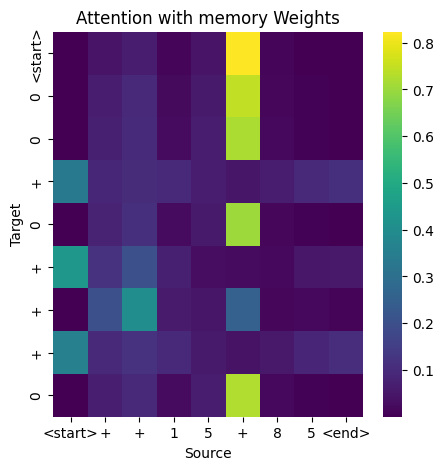

output.shape: torch.Size([1, 15])
output: tensor([[  3.7365,   3.7279,   3.6972,   3.7150,   3.7175,   3.6855,   3.6851,   3.7215,   3.7215,
           3.7080,   5.8408, -10.9960, -15.5556, -10.8730, -10.4760]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 9
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

     

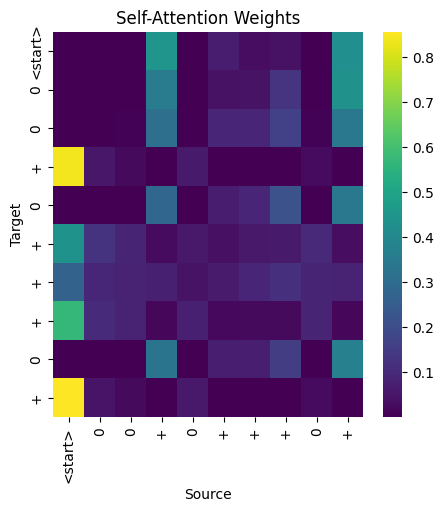

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 10, 9])
AV.shape: torch.Size([1, 10, 4])
multi_attention: 
[[4.3598479e-06 4.4208411e-02 6.2379785e-02 1.2502860e-02 4.2575665e-02
  8.2506847e-01 9.9543612e-03 2.5765777e-03 7.2952465e-04]
 [2.1030868e-05 6.4470604e-02 9.0034641e-02 2.0566940e-02 5.6075778e-02
  7.4672347e-01 1.5478608e-02 5.0784093e-03 1.5504855e-03]
 [3.3745866e-05 6.9790758e-02 9.5168449e-02 2.3733692e-02 6.2051449e-02
  7.2246355e-01 1.8421656e-02 6.3421819e-03 1.9945554e-03]
 [3.3234072e-01 8.9794166e-02 1.0248091e-01 9.3735278e-02 6.3576601e-02
  4.5374818e-02 6.3696906e-02 9.4140589e-02 1.1486003e-01]
 [3.4330275e-05 7.6454766e-02 1.1150345e-01 2.3868896e-02 5.7253849e-02
  7.0730072e-01 1.5836742e-02 5.9108566e-03 1.8363339e-03]
 [4.4120595e-01 1.1892352e-01 2.1603262e-01 7.0783086e-02 2.3260964e-02
  2.1100346e-02 1.5580980e-02 4.6141051e-02 4.6971384e-02]
 [7.5443235e-04 1.719106

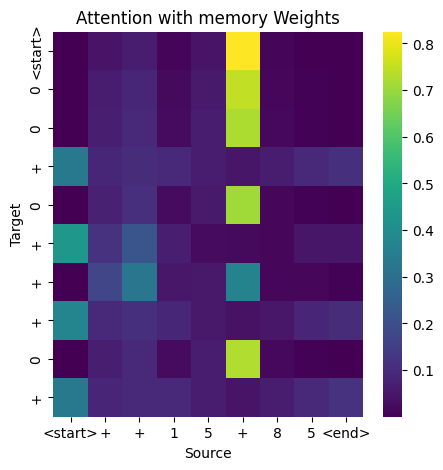

output.shape: torch.Size([1, 15])
output: tensor([[ 2.6651,  2.6586,  2.6429,  2.6480,  2.6498,  2.6399,  2.6335,  2.6589,  2.6515,  2.6520,
          0.2593, -7.0816,  0.6421, -8.5073, -8.0908]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 10
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

        [[ 4.

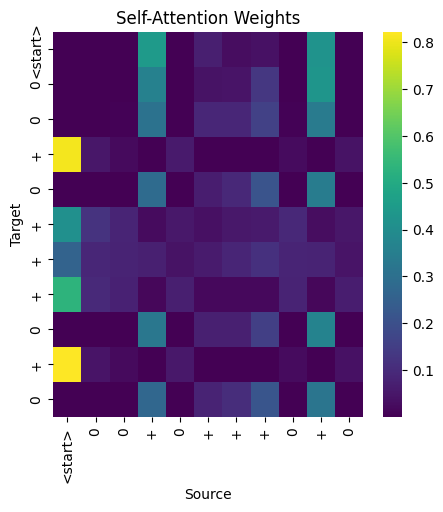

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 11, 9])
AV.shape: torch.Size([1, 11, 4])
multi_attention: 
[[4.35946731e-06 4.42078598e-02 6.23794384e-02 1.25025213e-02
  4.25746813e-02 8.25071216e-01 9.95397661e-03 2.57646339e-03
  7.29488151e-04]
 [2.10301841e-05 6.44710362e-02 9.00361538e-02 2.05667466e-02
  5.60748391e-02 7.46723413e-01 1.54781230e-02 5.07828500e-03
  1.55044103e-03]
 [3.37397978e-05 6.98072463e-02 9.52108651e-02 2.37325523e-02
  6.20340258e-02 7.22435534e-01 1.84119847e-02 6.34020707e-03
  1.99382962e-03]
 [3.55150878e-01 8.73067230e-02 1.00487933e-01 9.10004973e-02
  5.97948767e-02 4.16339822e-02 6.02005720e-02 9.18916538e-02
  1.12532854e-01]
 [3.43292886e-05 7.64590427e-02 1.11515157e-01 2.38686725e-02
  5.72500639e-02 7.07291245e-01 1.58348158e-02 5.91044826e-03
  1.83618756e-03]
 [3.82610768e-01 1.36308953e-01 2.65167803e-01 7.26434365e-02
  2.25936081e-02 2.31089238e-02 1.3787

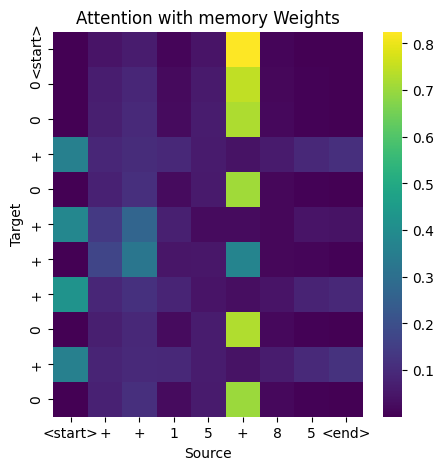

output.shape: torch.Size([1, 15])
output: tensor([[  3.6881,   3.6794,   3.6487,   3.6664,   3.6690,   3.6369,   3.6365,   3.6730,   3.6730,
           3.6594,   5.9766, -11.1953, -15.2466, -11.0473, -10.6537]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 11
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.37

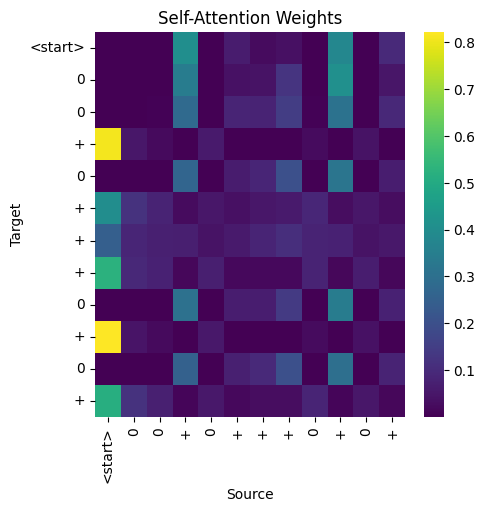

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 12, 9])
AV.shape: torch.Size([1, 12, 4])
multi_attention: 
[[4.38416919e-06 4.47698571e-02 6.36777729e-02 1.25349322e-02
  4.22318019e-02 8.23702276e-01 9.79442056e-03 2.56080856e-03
  7.23714475e-04]
 [2.09676873e-05 6.48295730e-02 9.09629986e-02 2.05514543e-02
  5.57330027e-02 7.46016800e-01 1.53014250e-02 5.04525332e-03
  1.53858832e-03]
 [3.32716809e-05 7.04239011e-02 9.69302431e-02 2.36387383e-02
  6.12249859e-02 7.21583664e-01 1.79690477e-02 6.23918418e-03
  1.95695995e-03]
 [3.55401725e-01 8.72691646e-02 1.00446627e-01 9.09685344e-02
  5.97585253e-02 4.15944606e-02 6.01719804e-02 9.18727145e-02
  1.12516209e-01]
 [3.39099352e-05 7.69061670e-02 1.12931699e-01 2.37786192e-02
  5.66589609e-02 7.06509352e-01 1.55381523e-02 5.83420834e-03
  1.80899398e-03]
 [3.05762947e-01 1.57412037e-01 3.26074749e-01 7.47870281e-02
  2.24962700e-02 2.65364423e-02 1.2466

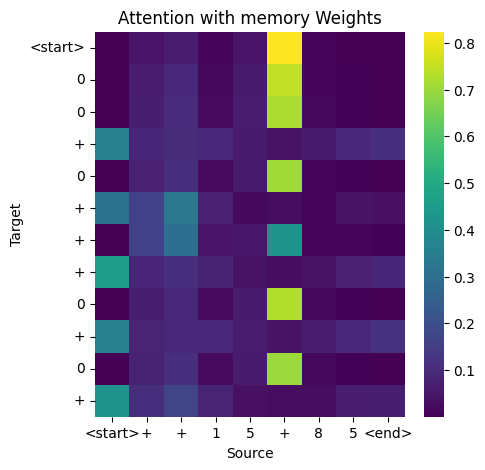

output.shape: torch.Size([1, 15])
output: tensor([[-2.9529, -2.9555, -2.9426, -2.9533, -2.9528, -2.9424, -2.9476, -2.9507, -2.9529, -2.9514,
          4.0029, -4.9040, 17.0722, -4.7620, -4.3381]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 12

------------------

Input: ++15+85
Decoded sequence: 00+0+++0+0+


In [48]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Attention with memory Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

### MDSを利用

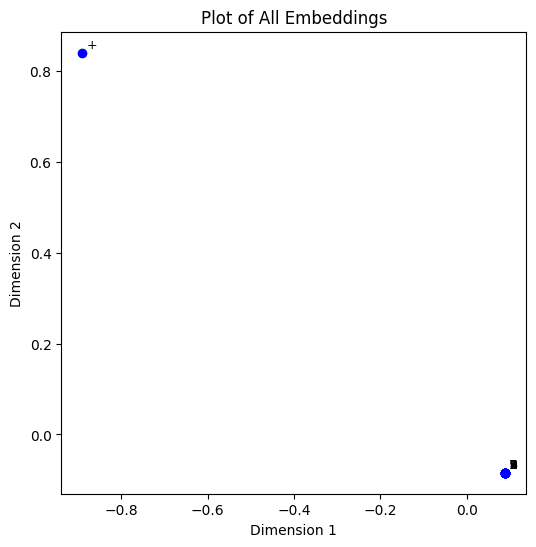

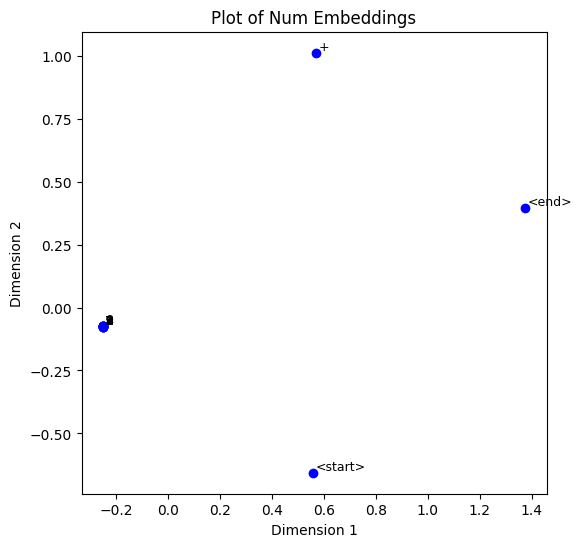

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt

# コサイン類似度に基づいてMDSで2次元に射影する関数
def apply_mds(embedding_weight, n_components=2):
    # コサイン類似度行列の計算
    cosine_sim = cosine_similarity(embedding_weight.cpu().detach().numpy())
    
    # 類似度を距離として扱うために、1 - コサイン類似度に変換
    distance_matrix = 1 - cosine_sim
    
    # MDSを適用して2次元に射影
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    embedding_2d_mds = mds.fit_transform(distance_matrix)
    
    return embedding_2d_mds

# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に射影された埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()

    if tgt_embed is not None:
        # TensorのままMDSを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しMDSを適用
        embed = np.vstack((embedded_weight.numpy(), tgt_embed.numpy()))
        embedded_weight_2d = apply_mds(torch.tensor(embed), n_components=2)
        tgt_embed_2d = embedded_weight_2d[-tgt_embed.shape[0]:]  # 最後のベクトルがターゲット埋め込み
        embedded_weight_2d = embedded_weight_2d[:-tgt_embed.shape[0]]  # 残りはもともとの埋め込み

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if tgt_embed.shape[0] == 1:
                label = "Taget"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='red', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, label, fontsize=9)
    else:
        # コサイン類似度に基づくMDSを適用してプロット
        embedded_weight_2d = apply_mds(embedded_weight, n_components=2)

    # MDSで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:11, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:13, :], title="Num Embeddings")


text: ++15+85
memory: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.1814, -1.8499,  1.3101,  2.5170]],

        [[ 0.2492, -2.8064,  1.3201,  2.5169]],

        [[-0.4127, -0.4247,  0.6257,  0.2290]],

        [[-1.3087, -0.0897,  0.6242,  0.2275]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.8327,  1.5232,  0.6538,  0.2272]],

        [[ 0.1051,  1.3178,  0.6542,  0.2259]],

        [[ 0.3699, -0.1823, -3.7036,  5.0313]]], device='cuda:0')
memory_size: torch.Size([9, 1, 4])

------------------

iter: 0
ys: tensor([[11]], device='cuda:0')


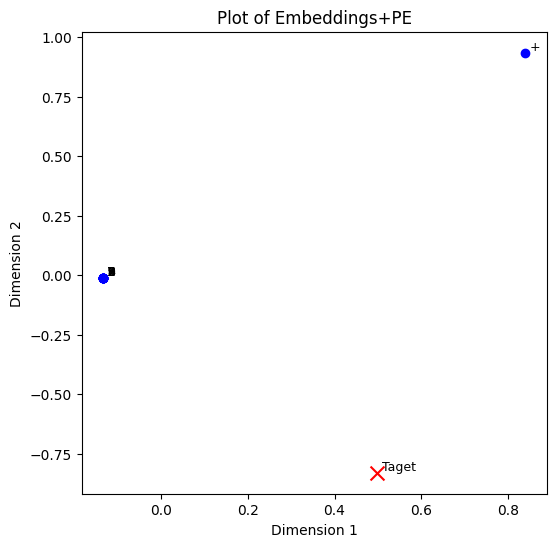

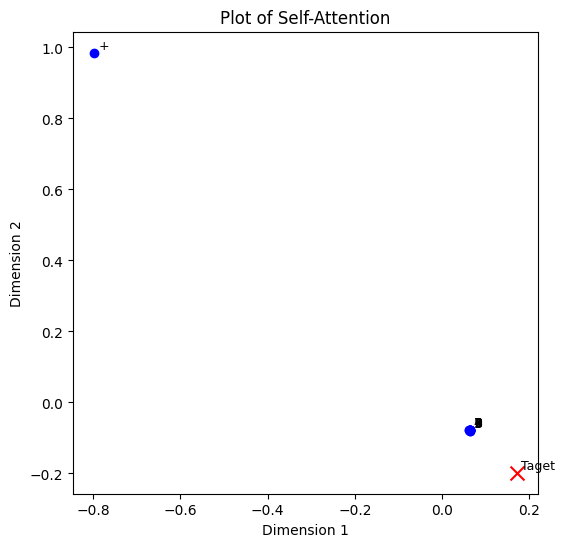

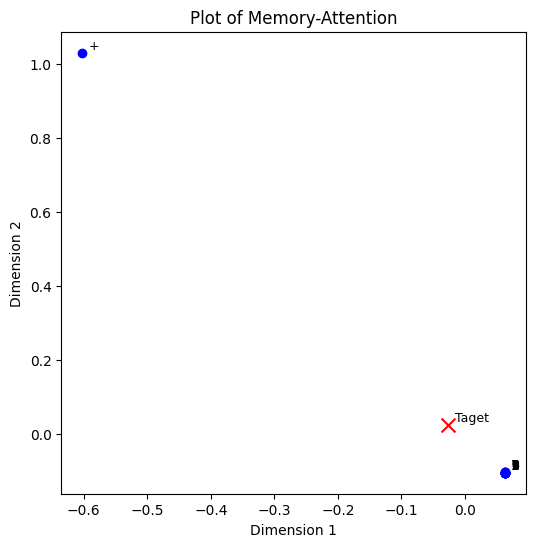

output.shape: torch.Size([1, 15])
output: tensor([[  4.7120,   4.7053,   4.6752,   4.6931,   4.6941,   4.6664,   4.6655,   4.7001,   4.6976,
           4.6887,   2.0324,  -7.4129, -17.1109,  -8.2308,  -7.7813]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[11],
        [ 0]], device='cuda:0')


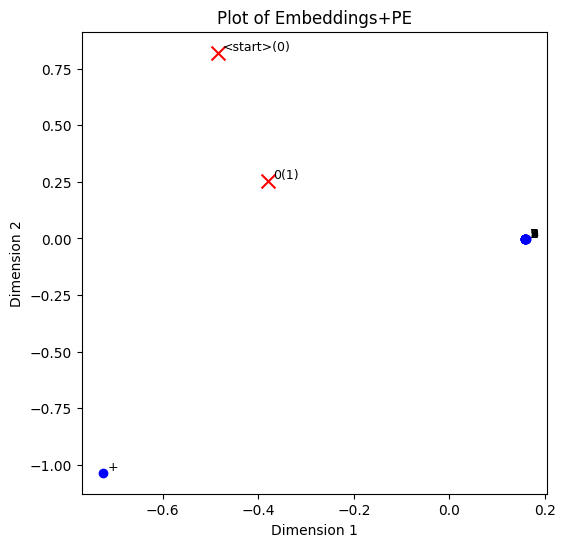

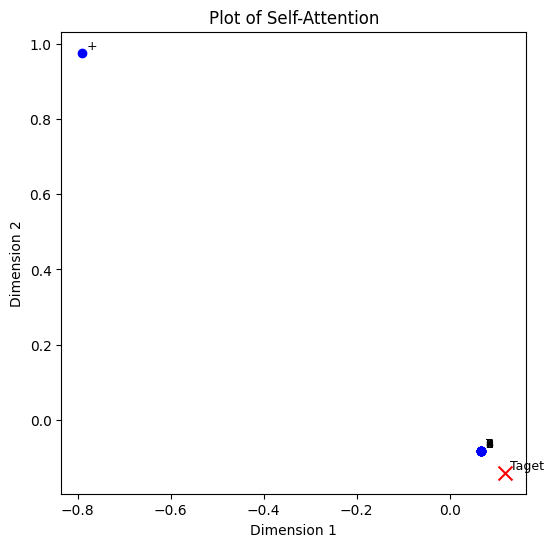

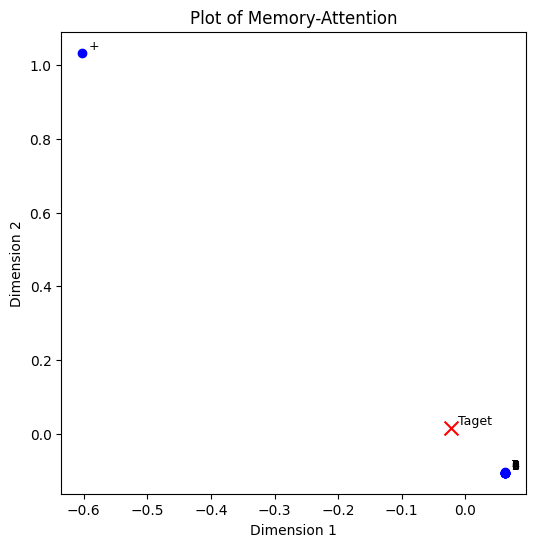

output.shape: torch.Size([1, 15])
output: tensor([[  4.8251,   4.8192,   4.7893,   4.8080,   4.8084,   4.7804,   4.7805,   4.8138,   4.8120,
           4.8027,   1.6938,  -6.3925, -19.0827,  -7.2118,  -6.7430]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 2
ys: tensor([[11],
        [ 0],
        [ 0]], device='cuda:0')


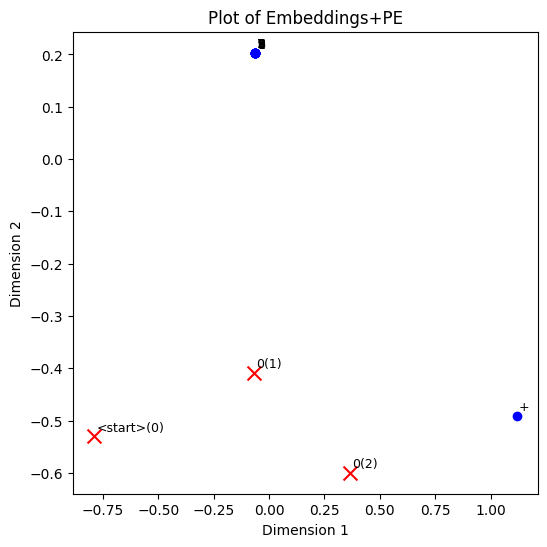

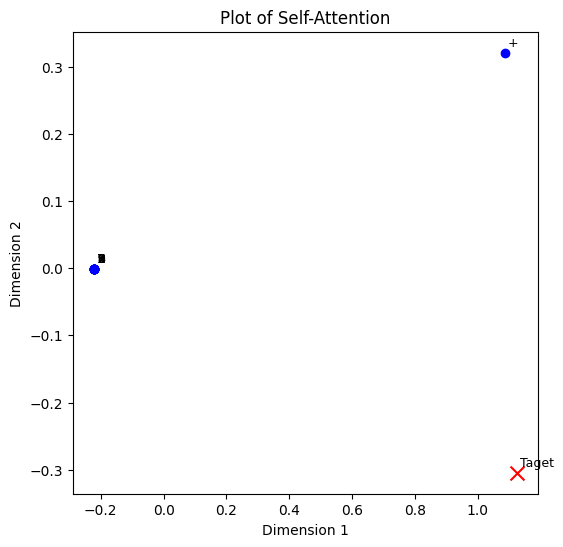

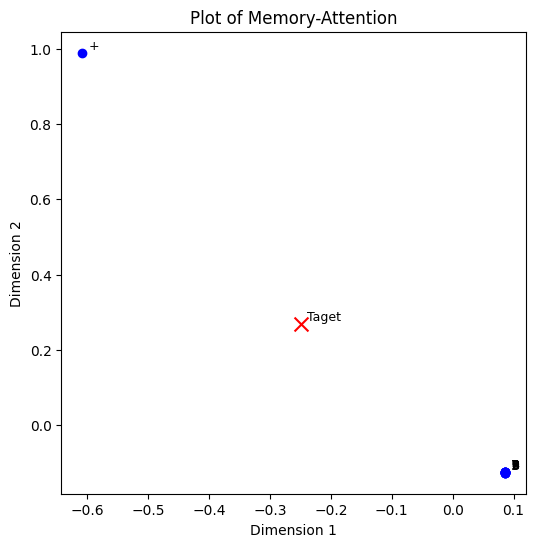

output.shape: torch.Size([1, 15])
output: tensor([[  2.5775,   2.5714,   2.5471,   2.5637,   2.5647,   2.5353,   2.5378,   2.5651,   2.5686,
           2.5531,   6.7215,  -8.6952, -16.9477,  -7.9931,  -7.5560]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 0],
        [ 0],
        [10]], device='cuda:0')


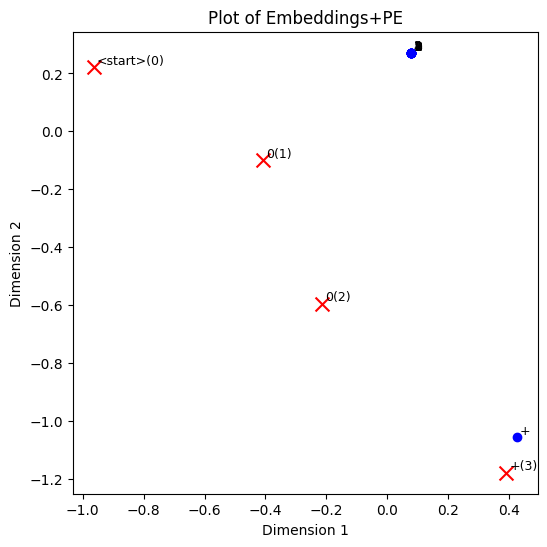

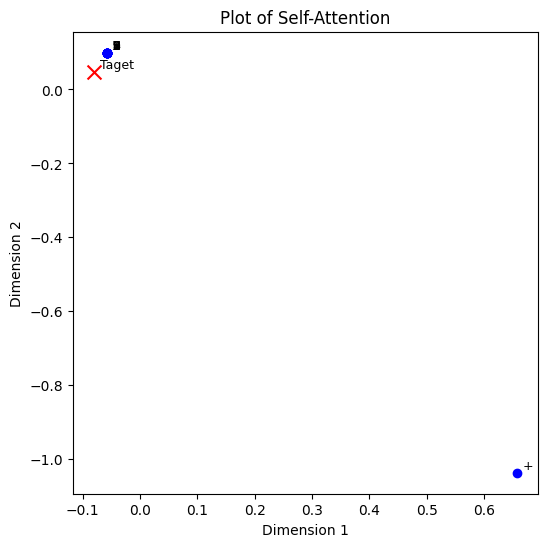

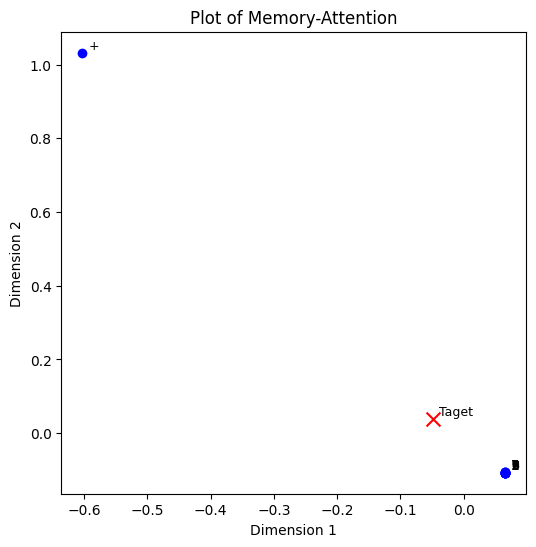

output.shape: torch.Size([1, 15])
output: tensor([[  4.2437,   4.2362,   4.2091,   4.2231,   4.2249,   4.2018,   4.1985,   4.2327,   4.2279,
           4.2221,   1.6372,  -8.2654, -10.8721,  -9.3273,  -8.9041]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 4
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0]], device='cuda:0')


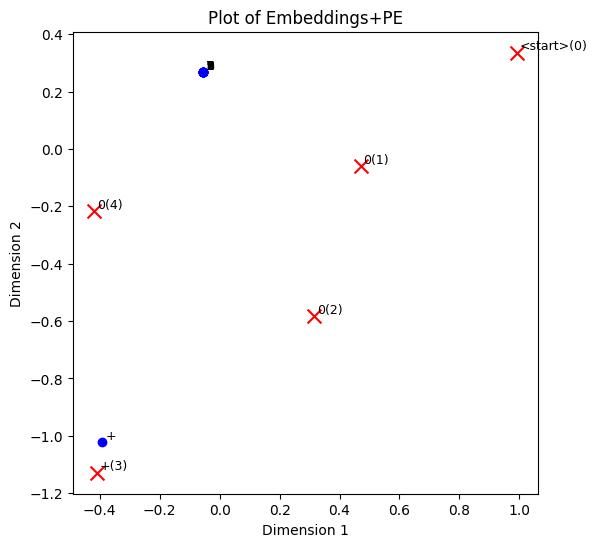

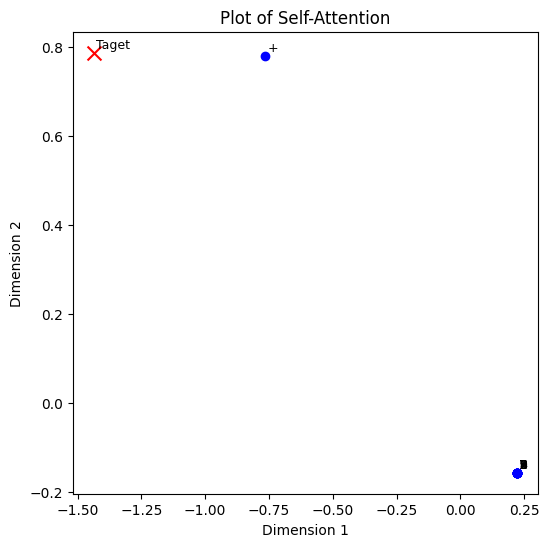

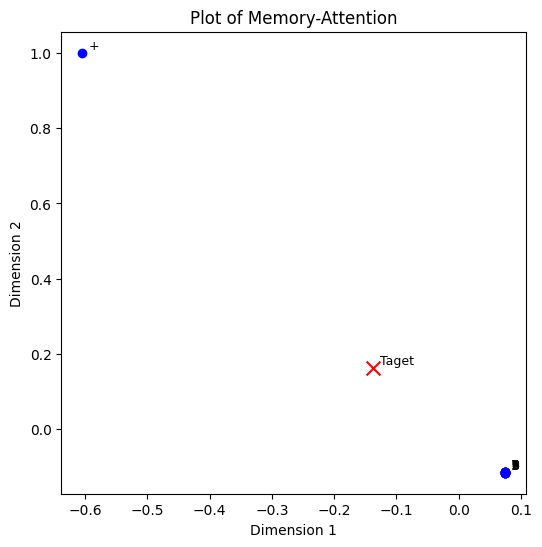

output.shape: torch.Size([1, 15])
output: tensor([[  3.7068,   3.6981,   3.6675,   3.6851,   3.6877,   3.6557,   3.6552,   3.6918,   3.6917,
           3.6782,   5.9220, -11.1719, -15.2315, -11.0406, -10.6467]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 5
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')


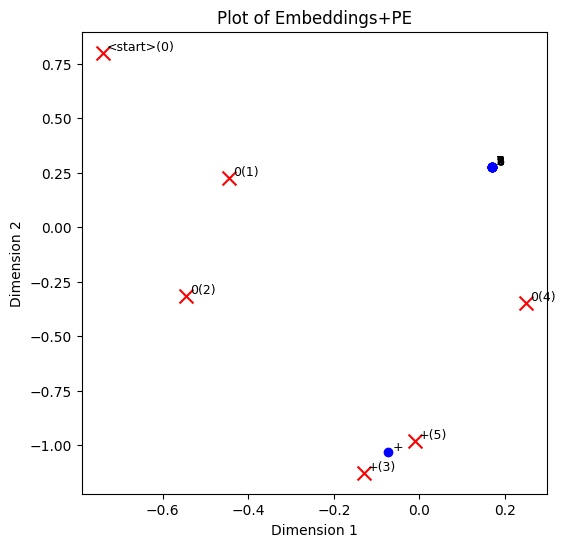

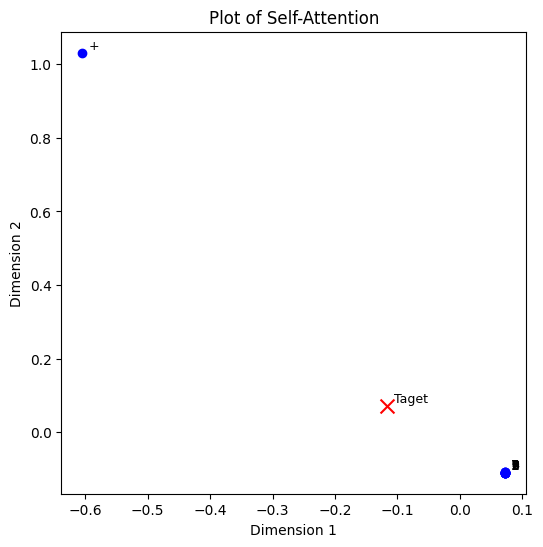

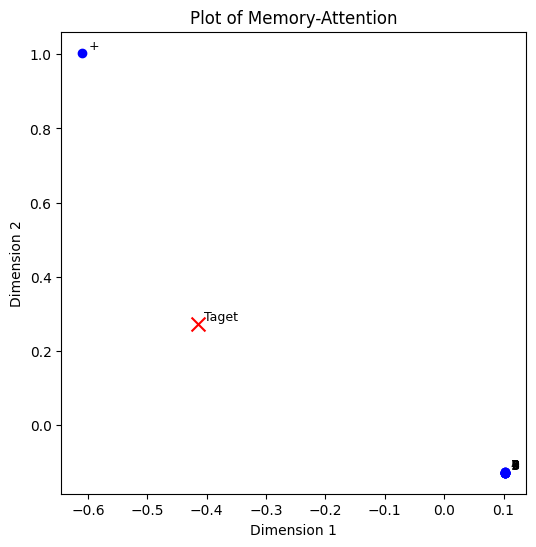

output.shape: torch.Size([1, 15])
output: tensor([[  1.7355,   1.7263,   1.7092,   1.7137,   1.7176,   1.7032,   1.6964,   1.7254,   1.7197,
           1.7161,   4.2436, -11.6569,   3.6829, -12.1947, -11.8487]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10]], device='cuda:0')


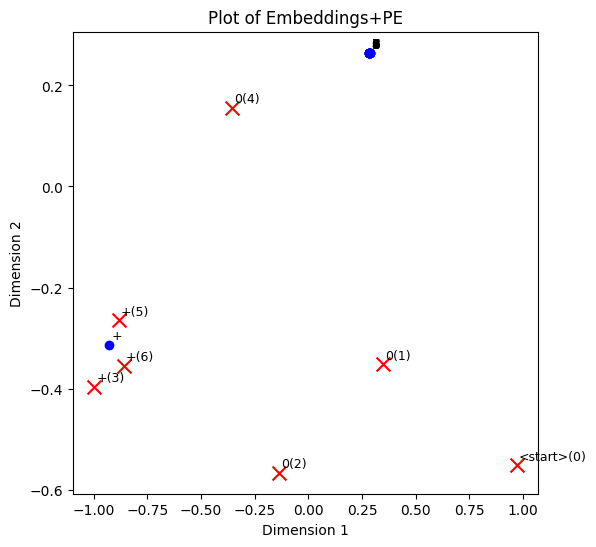

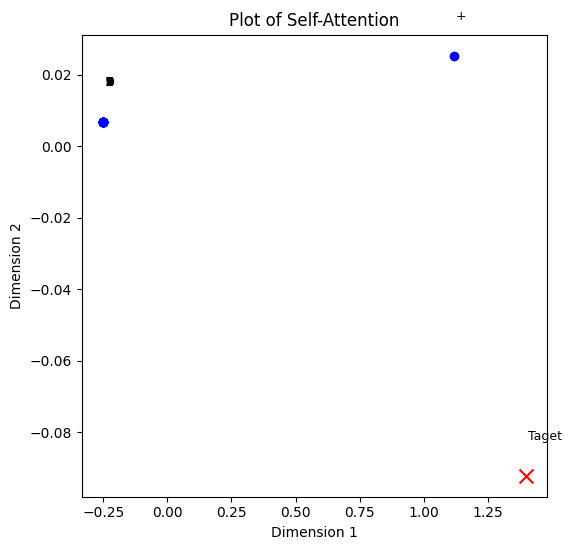

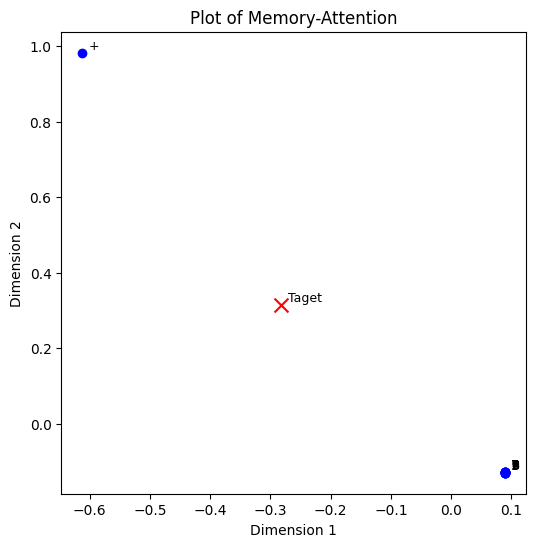

output.shape: torch.Size([1, 15])
output: tensor([[  2.3711,   2.3601,   2.3339,   2.3453,   2.3502,   2.3229,   2.3189,   2.3556,   2.3535,
           2.3421,   7.5851, -14.6313,  -4.4756, -14.3158, -13.9943]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10]], device='cuda:0')


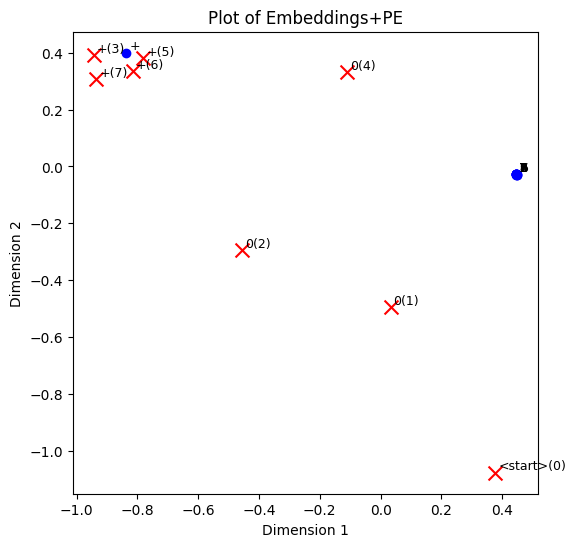

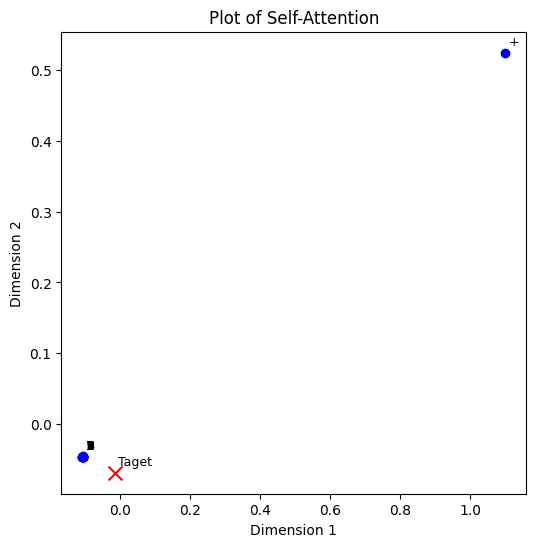

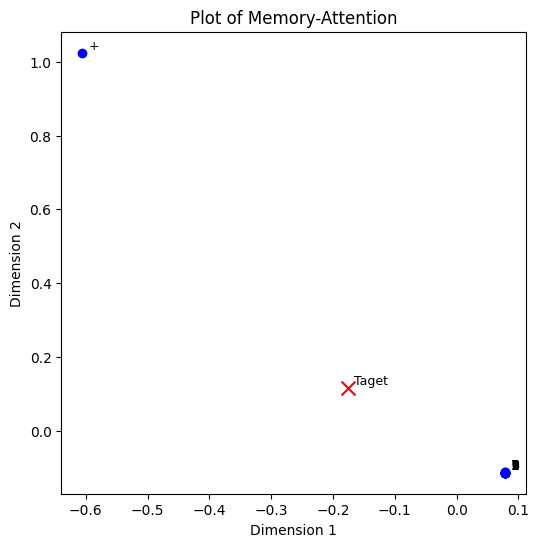

output.shape: torch.Size([1, 15])
output: tensor([[  3.2530,   3.2447,   3.2221,   3.2316,   3.2344,   3.2160,   3.2106,   3.2427,   3.2369,
           3.2329,   2.2744,  -9.5437,  -3.9353, -10.5321, -10.1415]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 8
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0]], device='cuda:0')


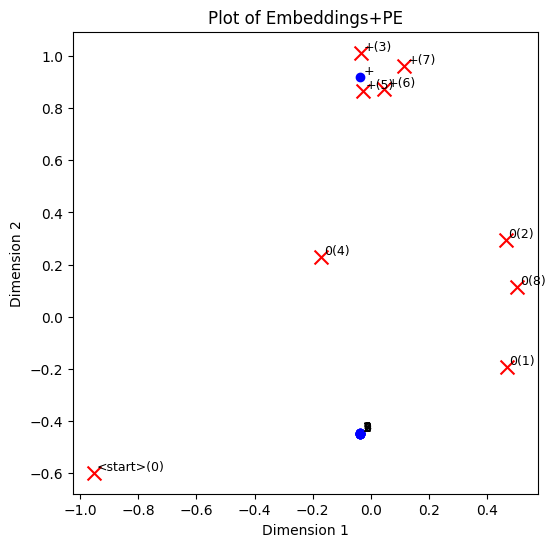

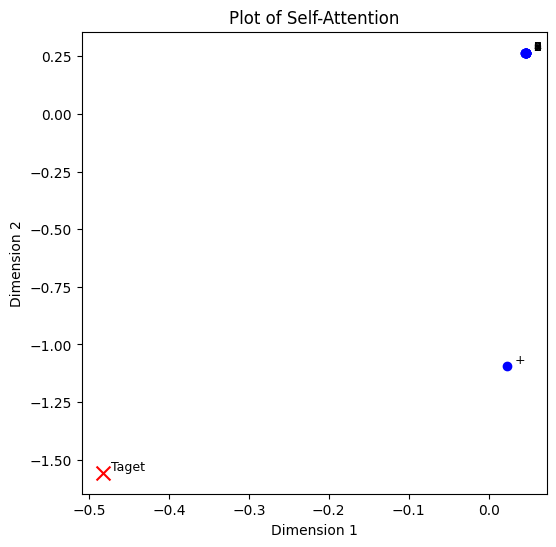

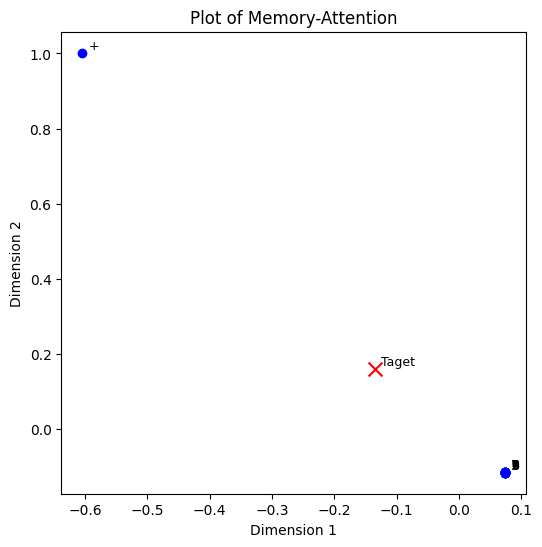

output.shape: torch.Size([1, 15])
output: tensor([[  3.7365,   3.7279,   3.6972,   3.7150,   3.7175,   3.6855,   3.6851,   3.7215,   3.7215,
           3.7080,   5.8408, -10.9960, -15.5556, -10.8730, -10.4760]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 9
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10]], device='cuda:0')


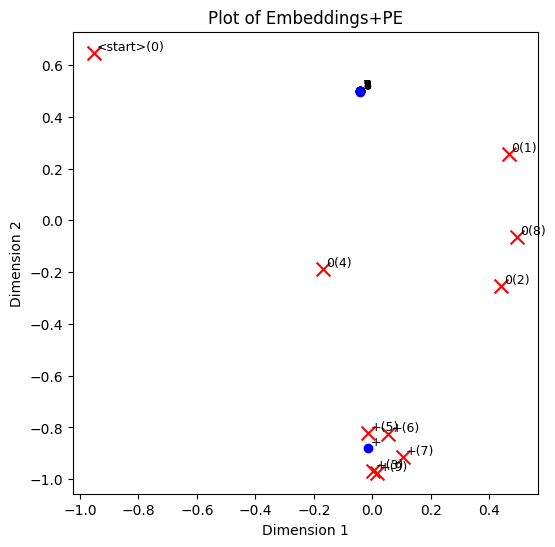

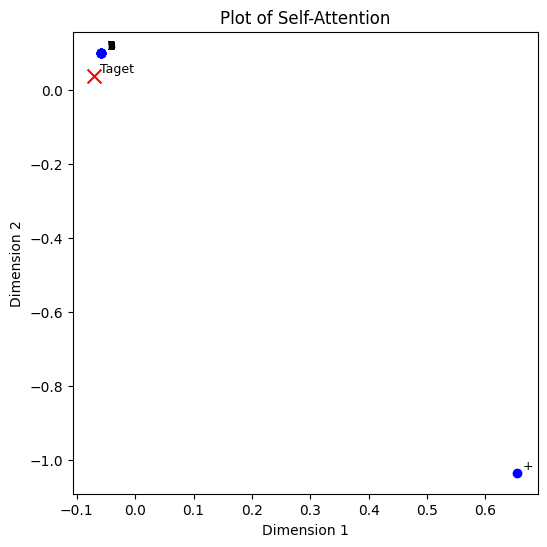

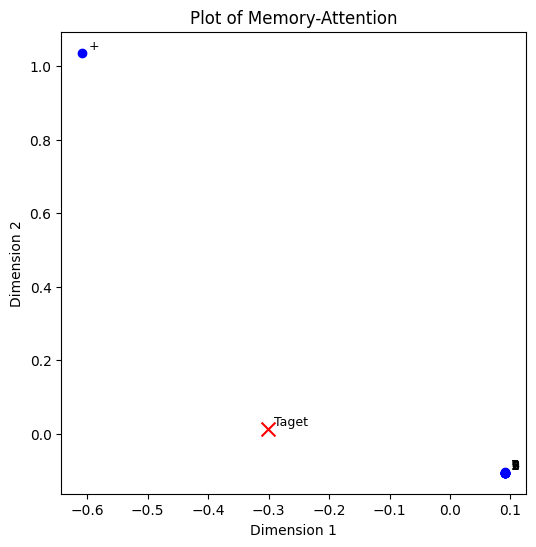

output.shape: torch.Size([1, 15])
output: tensor([[ 2.6651,  2.6586,  2.6429,  2.6480,  2.6498,  2.6399,  2.6335,  2.6589,  2.6515,  2.6520,
          0.2593, -7.0816,  0.6421, -8.5073, -8.0908]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 10
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0]], device='cuda:0')


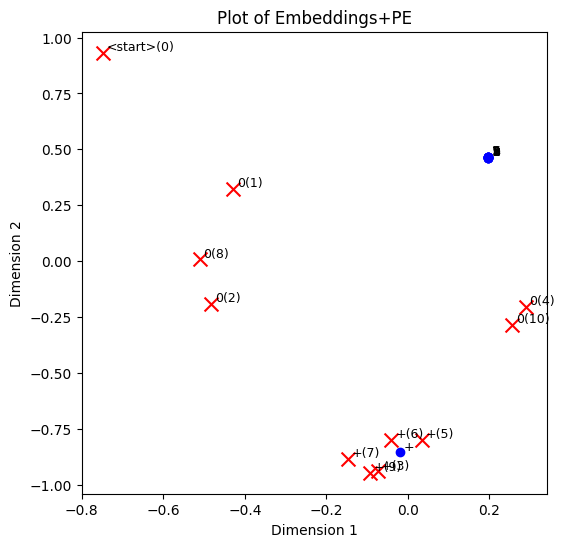

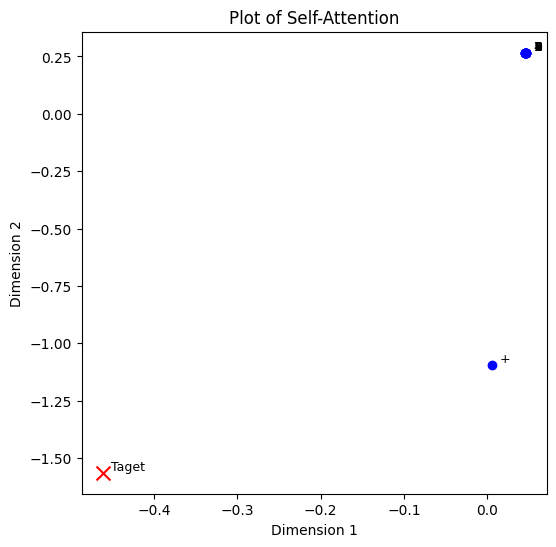

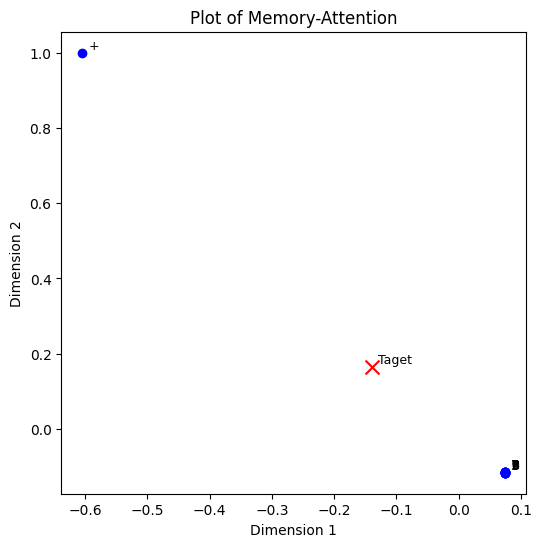

output.shape: torch.Size([1, 15])
output: tensor([[  3.6881,   3.6794,   3.6487,   3.6664,   3.6690,   3.6369,   3.6365,   3.6730,   3.6730,
           3.6594,   5.9766, -11.1953, -15.2466, -11.0473, -10.6537]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 11
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')


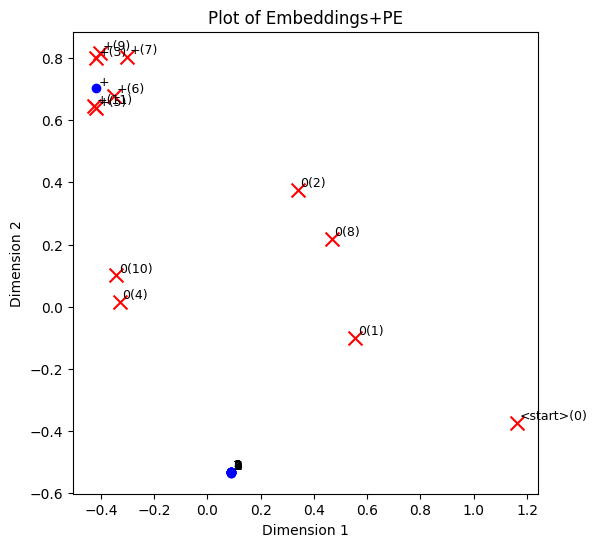

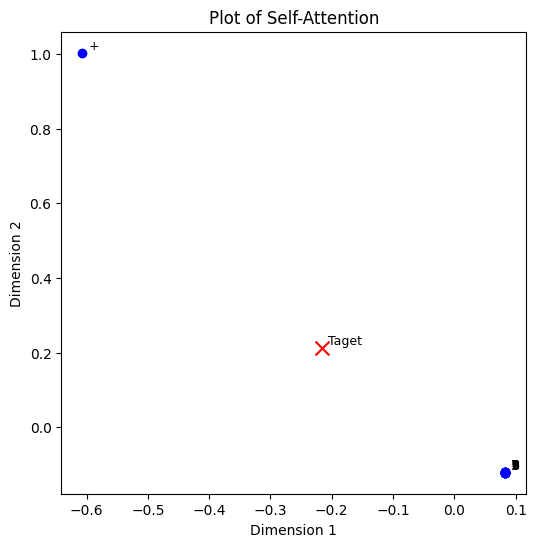

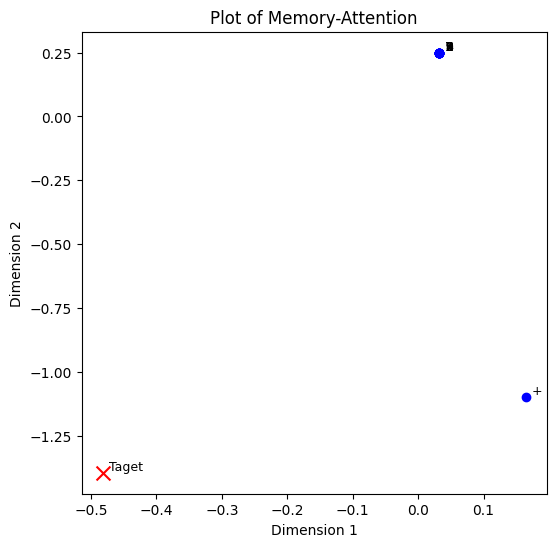

output.shape: torch.Size([1, 15])
output: tensor([[-2.9529, -2.9555, -2.9426, -2.9533, -2.9528, -2.9424, -2.9476, -2.9507, -2.9529, -2.9514,
          4.0029, -4.9040, 17.0722, -4.7620, -4.3381]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 12

------------------



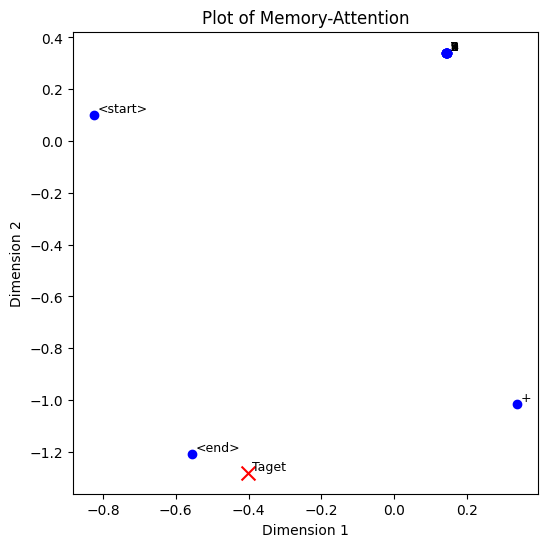

Input: ++15+85
Decoded sequence: 00+0+++0+0+


In [50]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt_embed, title="Embeddings+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Self-Attention")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break

# 最後に<end>の埋め込みまで計算
plot_embedding_tgt_2d(embedded_weight=embedding_weight[:13, :], ys=ys, tgt_embed=tgt[-1:, :], src=src, title="Memory-Attention")

flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

### PCAを利用

torch.Size([11, 4])


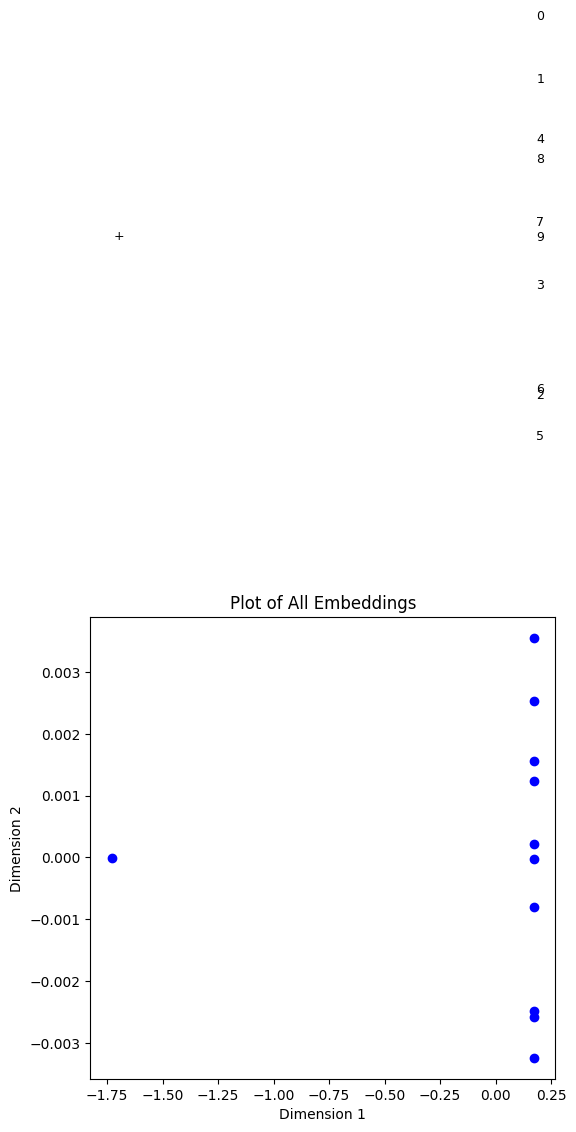

torch.Size([13, 4])


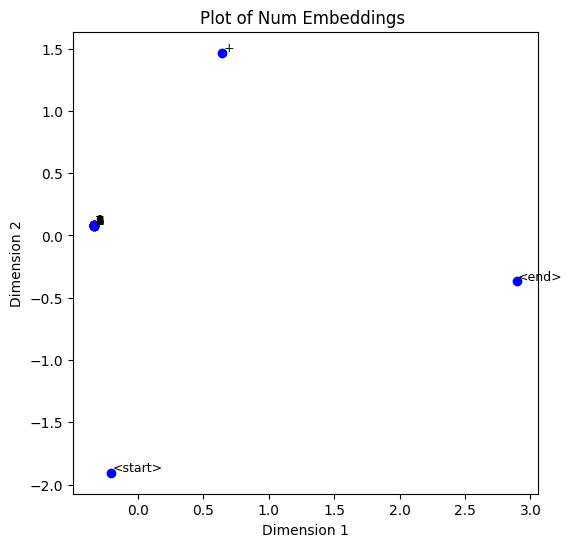

In [51]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# PCAを使って埋め込みベクトルを2次元に圧縮する関数
def apply_pca(embedding_weight, n_components=2):
    print(embedding_weight.shape)
    pca = PCA(n_components=n_components)
    embedding_2d = pca.fit_transform(embedding_weight.cpu().detach().numpy())
    return embedding_2d


# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に圧縮した埋め込みベクトルのプロット
# 2次元に圧縮した埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()


    if tgt_embed is not None:
        # TensorのままPCAを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しPCAを適用
        print(embedded_weight.shape)
        print(tgt_embed.shape)
        embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
        tgt_embed_2d = embed[-1:]
        embedded_weight_2d = embed[:-1]

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i) + label, fontsize=9)
    else:
        embedded_weight_2d = apply_pca(embedded_weight, n_components=2)

    # PCAで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:11, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:13, :], title="Num Embeddings ")


text: ++15+85
memory: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.1814, -1.8499,  1.3101,  2.5170]],

        [[ 0.2492, -2.8064,  1.3201,  2.5169]],

        [[-0.4127, -0.4247,  0.6257,  0.2290]],

        [[-1.3087, -0.0897,  0.6242,  0.2275]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.8327,  1.5232,  0.6538,  0.2272]],

        [[ 0.1051,  1.3178,  0.6542,  0.2259]],

        [[ 0.3699, -0.1823, -3.7036,  5.0313]]], device='cuda:0')
memory_size: torch.Size([9, 1, 4])

------------------

iter: 0
ys: tensor([[11]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


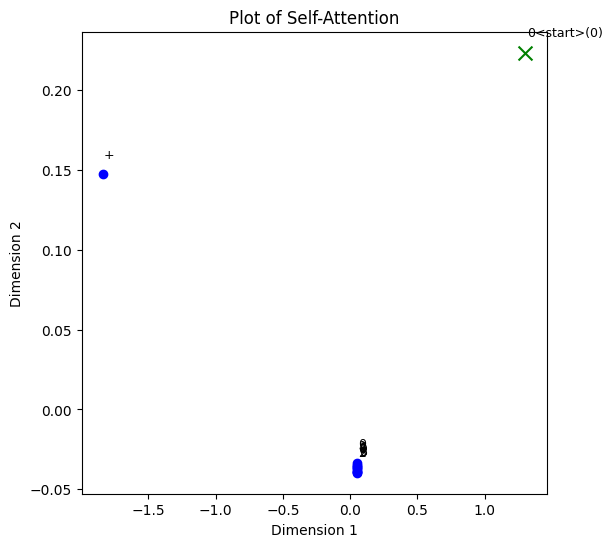

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 4])
After Attention: tensor([[[-4.7499,  0.8408,  6.2076, -3.3825]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


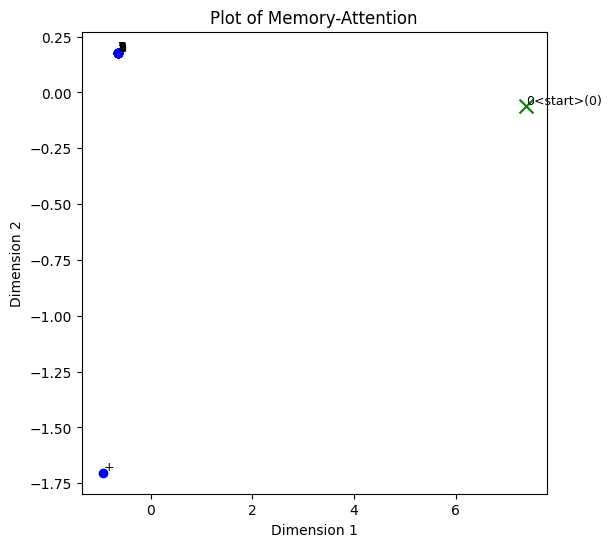

output.shape: torch.Size([1, 15])
output: tensor([[  4.7120,   4.7053,   4.6752,   4.6931,   4.6941,   4.6664,   4.6655,   4.7001,   4.6976,
           4.6887,   2.0324,  -7.4129, -17.1109,  -8.2308,  -7.7813]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 1
ys: tensor([[11],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]]], device='cuda:0')
now tgt: 0
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


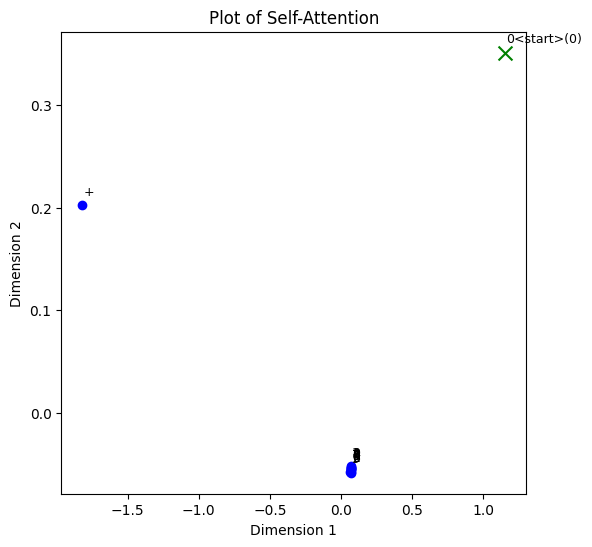

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 4])
After Attention: tensor([[[-4.4900,  0.3135,  6.5280, -3.4270]],

        [[-4.2056,  0.5924,  6.3720, -4.1245]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


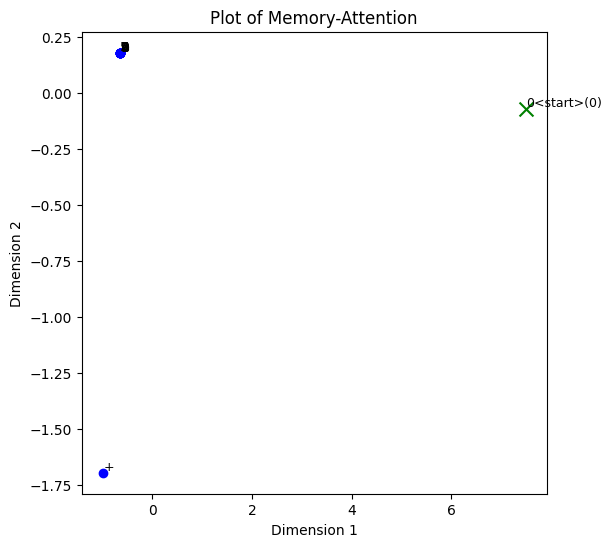

output.shape: torch.Size([1, 15])
output: tensor([[  4.8251,   4.8192,   4.7893,   4.8080,   4.8084,   4.7804,   4.7805,   4.8138,   4.8120,
           4.8027,   1.6938,  -6.3925, -19.0827,  -7.2118,  -6.7430]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 2
ys: tensor([[11],
        [ 0],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]]], device='cuda:0')
now tgt: 00
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


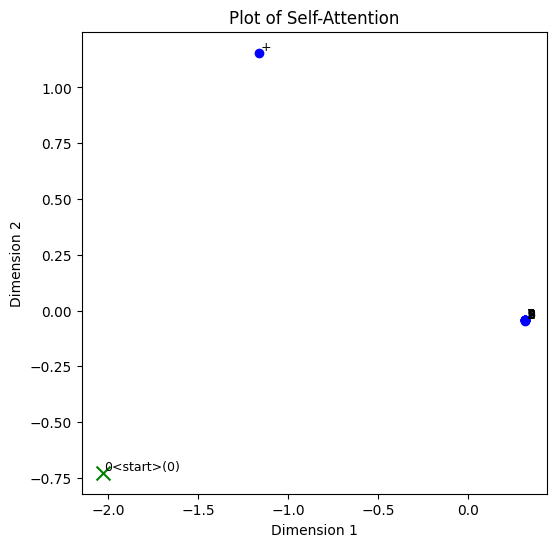

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 4])
After Attention: tensor([[[-4.4801,  0.0776,  6.6391, -3.2273]],

        [[-3.9036, -0.9363,  6.9942, -3.0996]],

        [[-1.8750, -3.1469,  6.5774, -2.5498]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


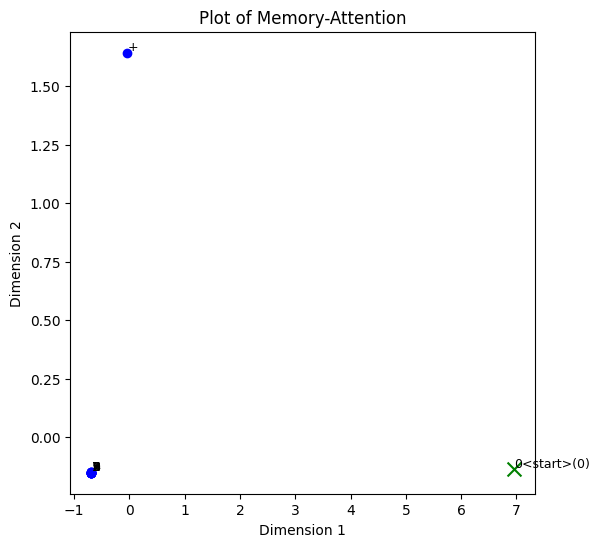

output.shape: torch.Size([1, 15])
output: tensor([[  2.5775,   2.5714,   2.5471,   2.5637,   2.5647,   2.5353,   2.5378,   2.5651,   2.5686,
           2.5531,   6.7215,  -8.6952, -16.9477,  -7.9931,  -7.5560]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 0],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]]], device='cuda:0')
now tgt: 00+
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


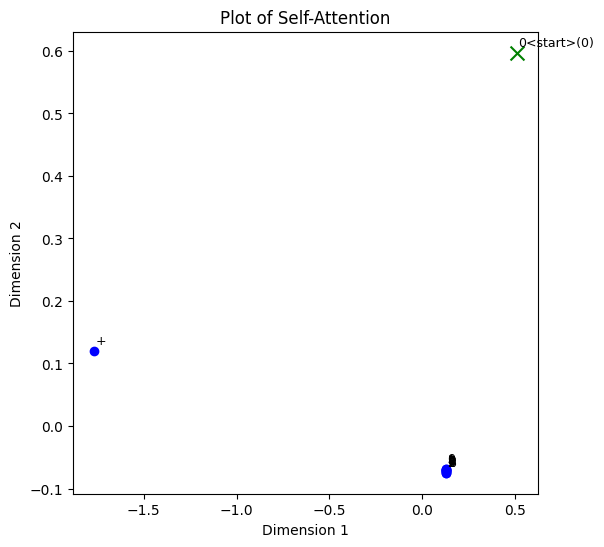

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 4])
After Attention: tensor([[[-4.4813, -0.8207,  6.9101, -2.2034]],

        [[-4.4879, -1.0131,  6.9322, -1.9266]],

        [[-4.4657, -1.0649,  6.9428, -1.8981]],

        [[-5.7880,  1.8934,  4.9499, -1.6190]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


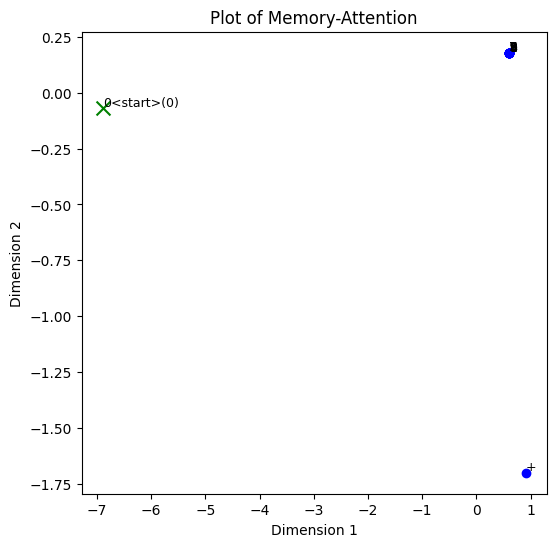

output.shape: torch.Size([1, 15])
output: tensor([[  4.2437,   4.2362,   4.2091,   4.2231,   4.2249,   4.2018,   4.1985,   4.2327,   4.2279,
           4.2221,   1.6372,  -8.2654, -10.8721,  -9.3273,  -8.9041]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 4
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]]], device='cuda:0')
now tgt: 00+0
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 5,

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


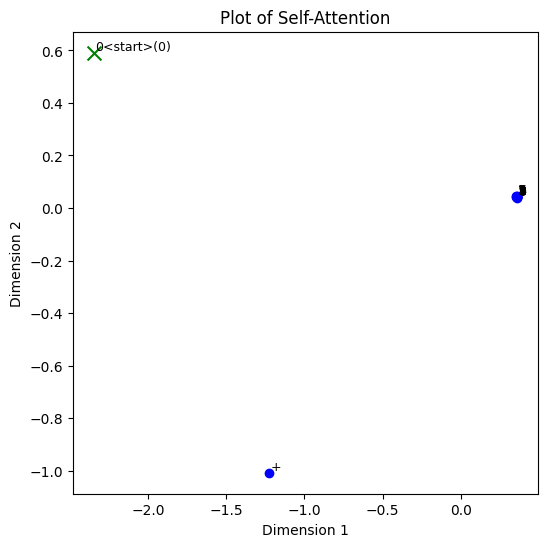

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 4])
After Attention: tensor([[[-4.4813e+00, -8.2069e-01,  6.9100e+00, -2.2034e+00]],

        [[-4.4879e+00, -1.0131e+00,  6.9322e+00, -1.9266e+00]],

        [[-4.4662e+00, -1.0649e+00,  6.9427e+00, -1.8971e+00]],

        [[-6.1902e+00,  2.5108e+00,  3.4985e+00,  4.3907e-03]],

        [[-4.5337e+00, -1.0589e+00,  6.9213e+00, -1.7656e+00]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


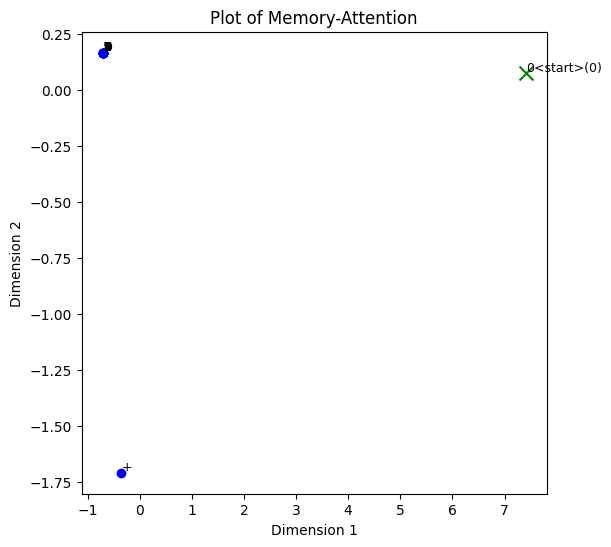

output.shape: torch.Size([1, 15])
output: tensor([[  3.7068,   3.6981,   3.6675,   3.6851,   3.6877,   3.6557,   3.6552,   3.6918,   3.6917,
           3.6782,   5.9220, -11.1719, -15.2315, -11.0406, -10.6467]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 5
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]]], device='cuda:0')
now tgt: 00+0+
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


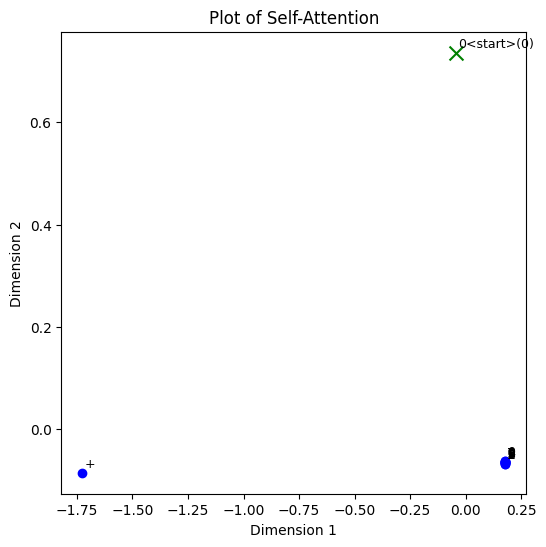

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 4])
After Attention: tensor([[[-4.4877, -0.8247,  6.9091, -2.1853]],

        [[-4.4948, -1.0145,  6.9303, -1.9104]],

        [[-4.4820, -1.0668,  6.9381, -1.8618]],

        [[-6.1928,  2.5189,  3.4732,  0.0295]],

        [[-4.5485, -1.0599,  6.9164, -1.7330]],

        [[-6.3970,  1.5614,  2.4591,  3.1639]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


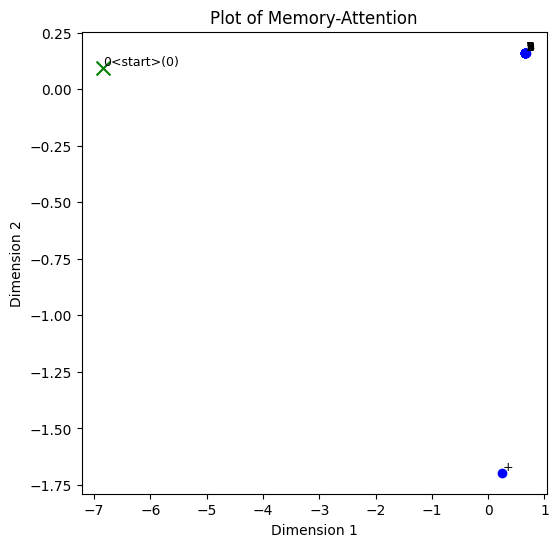

output.shape: torch.Size([1, 15])
output: tensor([[  1.7355,   1.7263,   1.7092,   1.7137,   1.7176,   1.7032,   1.6964,   1.7254,   1.7197,
           1.7161,   4.2436, -11.6569,   3.6829, -12.1947, -11.8487]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.3301,  2.5166]],

        [[-1.3122, -0.0887,  0.6375,  0.2301]],

        [[-1.6190, -2.1066,  1.3501,  2.5158]],

        [[-0.9395, -1.4301,  1.3601,  2.5153]]], device='cuda:0')
now tgt: 00+0++
tgt_embed: tensor([[[ 1.9306,  2.3368, -2.3462, -1.3014]],

        [[ 0.2861,  1.1052,  0.6075,  0.2308]],

        [[ 0.3539,  0.1488,  0.6175,  0.2307]],

        [[-0.5190, -3.3802,  1.33

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


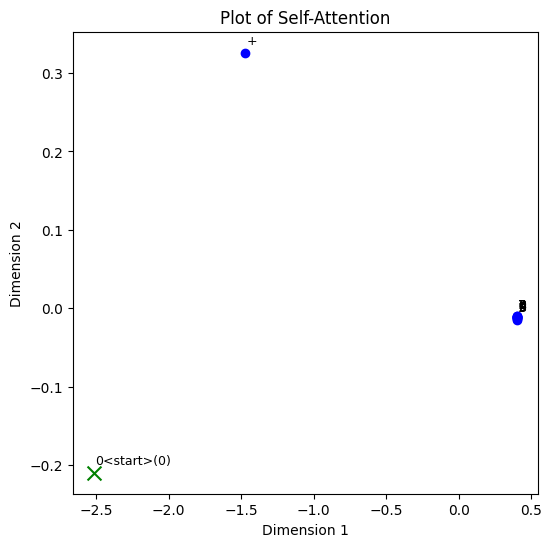

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 4])
After Attention: tensor([[[-4.4878, -0.8253,  6.9092, -2.1843]],

        [[-4.4955, -1.0183,  6.9304, -1.9035]],

        [[-4.4815, -1.0748,  6.9388, -1.8515]],

        [[-6.1954,  2.5277,  3.4456,  0.0564]],

        [[-4.5512, -1.0686,  6.9160, -1.7148]],

        [[-3.6765, -0.1224, -1.6877,  6.6329]],

        [[-5.9671, -0.5700,  5.3740,  1.8996]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


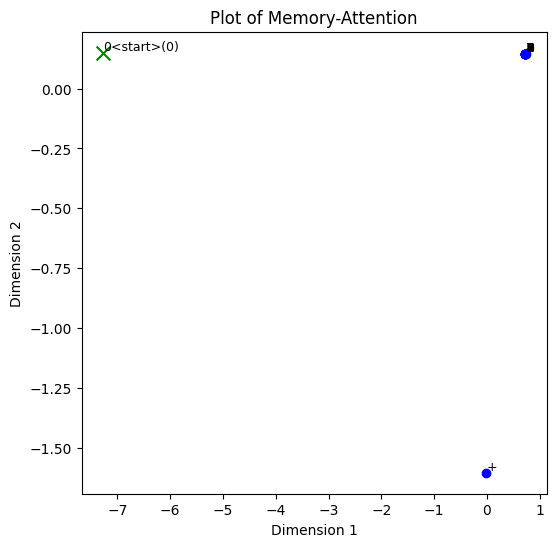

output.shape: torch.Size([1, 15])
output: tensor([[  2.3711,   2.3601,   2.3339,   2.3453,   2.3502,   2.3229,   2.3189,   2.3556,   2.3535,
           2.3421,   7.5851, -14.6313,  -4.4756, -14.3158, -13.9943]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]]], device='cuda:0')
now tgt: 00+0+++

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


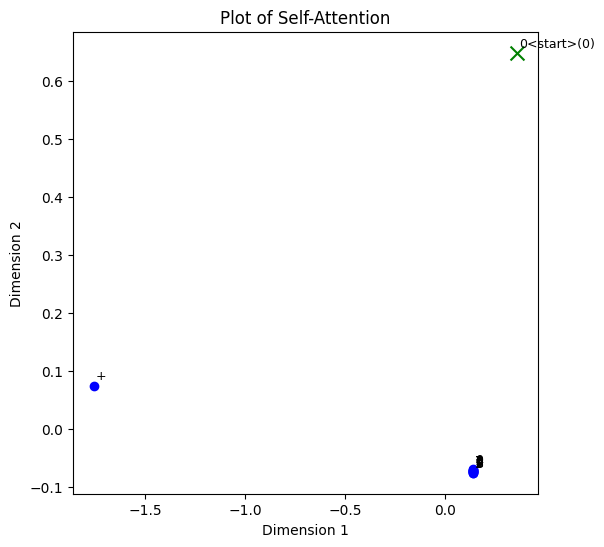

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 4])
After Attention: tensor([[[-4.4847, -0.8245,  6.9098, -2.1916]],

        [[-4.4809, -1.0293,  6.9356, -1.9178]],

        [[-4.4619, -1.0898,  6.9457, -1.8700]],

        [[-6.1964,  2.5316,  3.4338,  0.0678]],

        [[-4.5295, -1.0894,  6.9243, -1.7300]],

        [[-1.3412, -1.3532, -2.6117,  5.8336]],

        [[-5.3746, -1.0748,  6.3135,  0.4559]],

        [[-6.3108,  2.1646,  3.6567,  0.5292]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


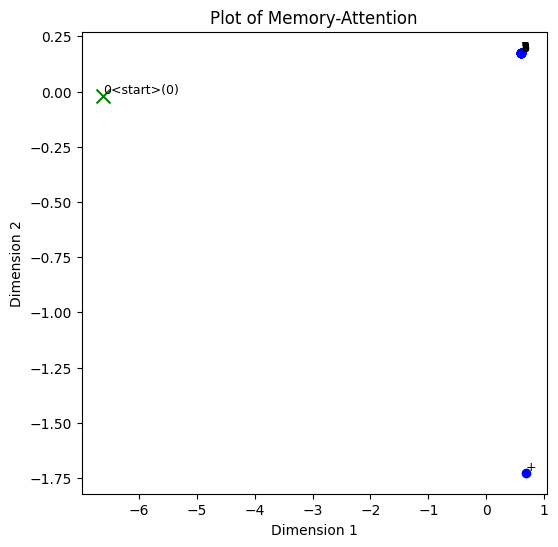

output.shape: torch.Size([1, 15])
output: tensor([[  3.2530,   3.2447,   3.2221,   3.2316,   3.2344,   3.2160,   3.2106,   3.2427,   3.2369,
           3.2329,   2.2744,  -9.5437,  -3.9353, -10.5321, -10.1415]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 8
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

        [[ 4.3396e-0

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


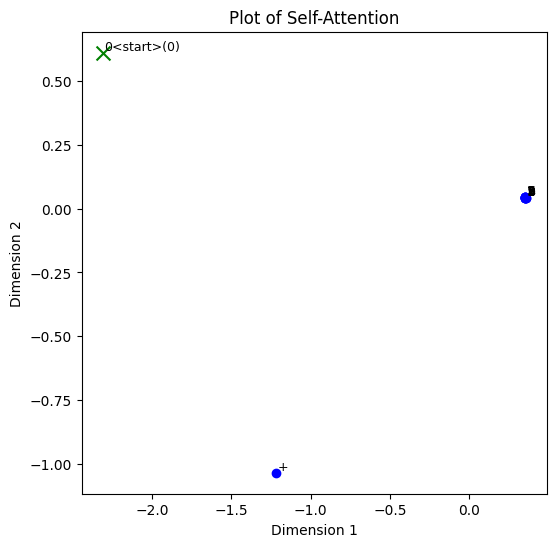

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 9, 9])
AV.shape: torch.Size([1, 9, 4])
After Attention: tensor([[[-4.4847, -0.8245,  6.9098, -2.1916]],

        [[-4.4809, -1.0293,  6.9356, -1.9178]],

        [[-4.4615, -1.0902,  6.9458, -1.8702]],

        [[-6.1205,  2.8769,  1.7360,  1.6333]],

        [[-4.5296, -1.0894,  6.9243, -1.7298]],

        [[-1.1854, -1.6012, -2.4884,  5.7924]],

        [[-5.4122, -1.0568,  6.2695,  0.5488]],

        [[-3.8672,  1.3269, -2.2521,  5.4685]],

        [[-4.4590, -1.0786,  6.9458, -1.8921]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


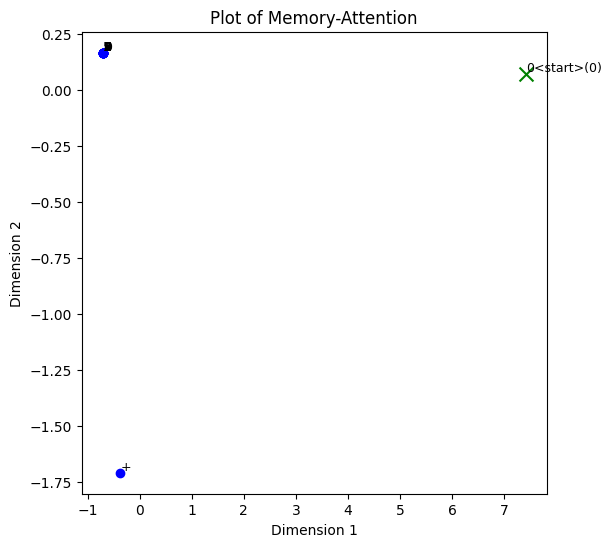

output.shape: torch.Size([1, 15])
output: tensor([[  3.7365,   3.7279,   3.6972,   3.7150,   3.7175,   3.6855,   3.6851,   3.7215,   3.7215,
           3.7080,   5.8408, -10.9960, -15.5556, -10.8730, -10.4760]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 9
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

     

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


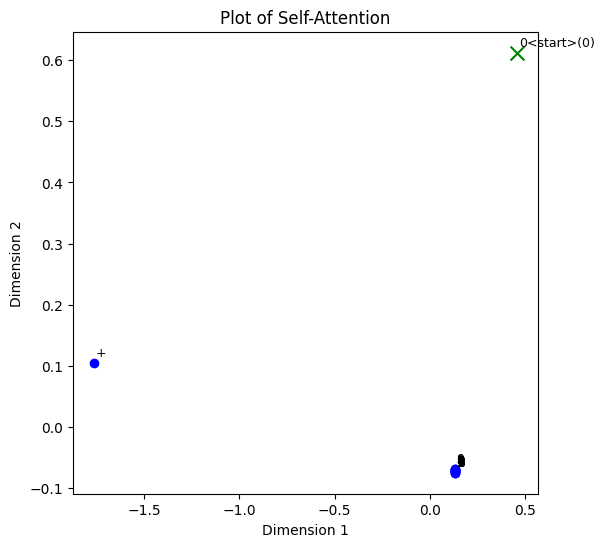

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 10, 9])
AV.shape: torch.Size([1, 10, 4])
After Attention: tensor([[[-4.4770, -0.8212,  6.9112, -2.2114]],

        [[-4.4749, -1.0256,  6.9370, -1.9354]],

        [[-4.4555, -1.0847,  6.9472, -1.8904]],

        [[-6.1193,  2.8777,  1.7289,  1.6393]],

        [[-4.5234, -1.0827,  6.9261, -1.7527]],

        [[-1.2149, -1.8514, -2.2563,  5.9215]],

        [[-5.1273, -1.1545,  6.5643, -0.1623]],

        [[-1.9813,  0.2644, -3.2749,  5.2900]],

        [[-4.4531, -1.0735,  6.9471, -1.9114]],

        [[-6.0326,  3.1043,  1.7760,  1.0859]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


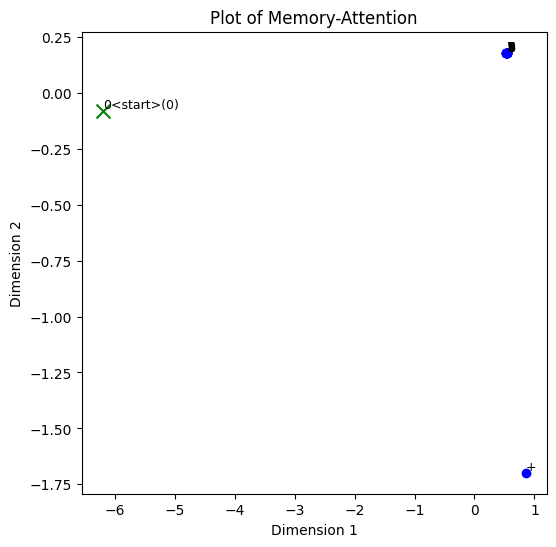

output.shape: torch.Size([1, 15])
output: tensor([[ 2.6651,  2.6586,  2.6429,  2.6480,  2.6498,  2.6399,  2.6335,  2.6589,  2.6515,  2.6520,
          0.2593, -7.0816,  0.6421, -8.5073, -8.0908]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 0

------------------

iter: 10
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.3701e+00,  2.5146e+00]],

        [[ 4.

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


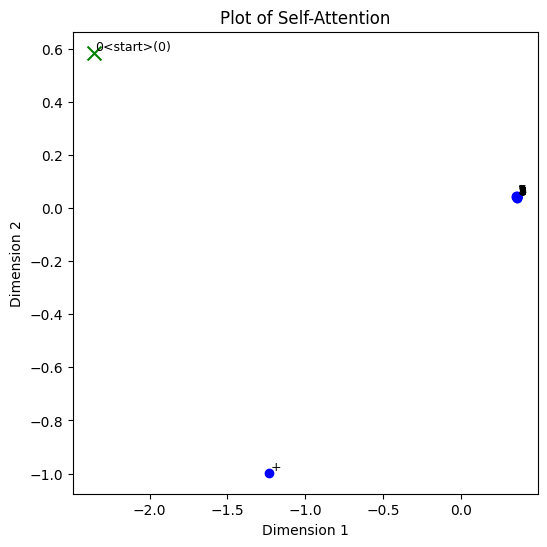

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 11, 9])
AV.shape: torch.Size([1, 11, 4])
After Attention: tensor([[[-4.4770, -0.8211,  6.9112, -2.2114]],

        [[-4.4749, -1.0256,  6.9370, -1.9353]],

        [[-4.4557, -1.0847,  6.9471, -1.8900]],

        [[-3.5447,  1.8063, -2.6871,  4.7653]],

        [[-4.5235, -1.0826,  6.9260, -1.7526]],

        [[-2.4010, -1.9631, -1.3287,  6.8568]],

        [[-5.1430, -1.1319,  6.5547, -0.1582]],

        [[-0.5717, -0.7632, -3.3009,  4.5480]],

        [[-4.4532, -1.0735,  6.9470, -1.9112]],

        [[-3.2575,  1.9935, -2.9523,  4.3466]],

        [[-4.5070, -1.1018,  6.9324, -1.7590]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


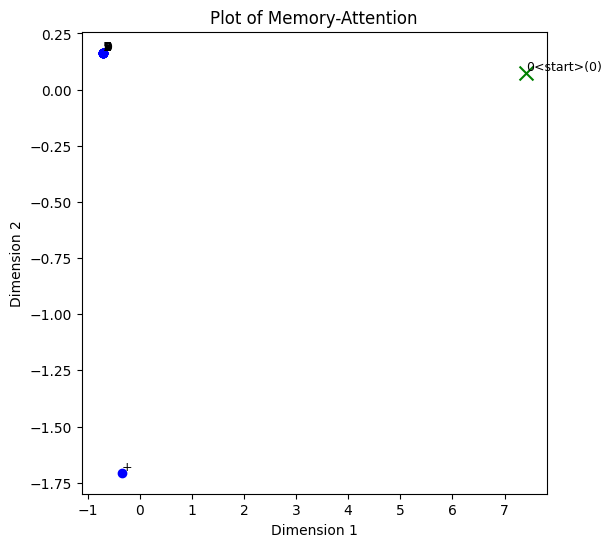

output.shape: torch.Size([1, 15])
output: tensor([[  3.6881,   3.6794,   3.6487,   3.6664,   3.6690,   3.6369,   3.6365,   3.6730,   3.6730,
           3.6594,   5.9766, -11.1953, -15.2466, -11.0473, -10.6537]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 11
ys: tensor([[11],
        [ 0],
        [ 0],
        [10],
        [ 0],
        [10],
        [10],
        [10],
        [ 0],
        [10],
        [ 0],
        [10]], device='cuda:0')
tgt_embed: tensor([[[ 1.9306e+00,  2.3368e+00, -2.3462e+00, -1.3014e+00]],

        [[ 2.8607e-01,  1.1052e+00,  6.0755e-01,  2.3082e-01]],

        [[ 3.5390e-01,  1.4877e-01,  6.1755e-01,  2.3067e-01]],

        [[-5.1897e-01, -3.3802e+00,  1.3301e+00,  2.5166e+00]],

        [[-1.3122e+00, -8.8724e-02,  6.3754e-01,  2.3007e-01]],

        [[-1.6190e+00, -2.1066e+00,  1.3501e+00,  2.5158e+00]],

        [[-9.3951e-01, -1.4301e+00,  1.3601e+00,  2.5153e+00]],

        [[-3.1058e-03, -1.6363e+00,  1.37

/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


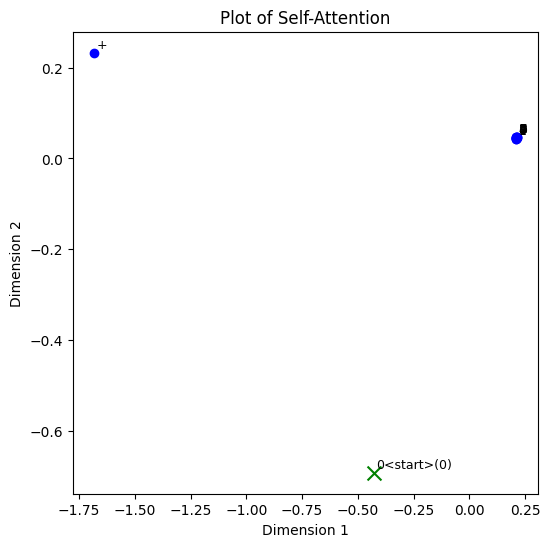

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 12, 9])
AV.shape: torch.Size([1, 12, 4])
After Attention: tensor([[[-4.4826, -0.8244,  6.9103, -2.1959]],

        [[-4.4792, -1.0254,  6.9358, -1.9269]],

        [[-4.4645, -1.0827,  6.9444, -1.8749]],

        [[-3.5082,  1.7843, -2.7148,  4.7742]],

        [[-4.5303, -1.0806,  6.9237, -1.7413]],

        [[-4.2120, -1.9119,  0.8029,  7.0095]],

        [[-5.0472, -1.1406,  6.6370, -0.4123]],

        [[-0.2243, -1.0018, -3.2221,  4.2313]],

        [[-4.4606, -1.0722,  6.9448, -1.8980]],

        [[-3.2247,  1.9720, -2.9751,  4.3544]],

        [[-4.5151, -1.0990,  6.9296, -1.7463]],

        [[-1.2365, -1.0515, -2.8867,  5.5565]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 4])
torch.Size([1, 4])
torch.Size([12, 4])


/tmp/ipykernel_261585/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


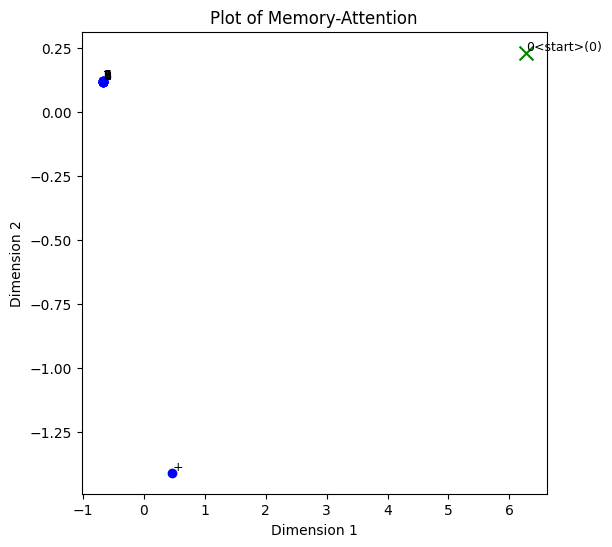

output.shape: torch.Size([1, 15])
output: tensor([[-2.9529, -2.9555, -2.9426, -2.9533, -2.9528, -2.9424, -2.9476, -2.9507, -2.9529, -2.9514,
          4.0029, -4.9040, 17.0722, -4.7620, -4.3381]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 12

------------------

Input: ++15+85
Decoded sequence: 00+0+++0+0+


In [52]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [41]:
import torch
from torch import nn
import torch.nn.functional as F


In [42]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [ ]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

In [ ]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



In [ ]:
from pprint import pprint
pprint(list(model.named_parameters()))

In [46]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [47]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [ ]:
print(attn_weights_)
print(attn_output_weights)

In [49]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [ ]:
print(attn_output_)
print(attn_output)

## nn.Linear

In [ ]:
model = nn.Linear(4, 4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [ ]:
model = nn.LayerNorm(4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)